# NOTE: Scroll Down to County Report for instructions on use.
Just loading the PPP dataset will take considerable time.  Generating multiple reports in one session by editing and rerunning the blocks of code in the County Report section after running the whole notebook once is advised.  If storage space / generating time is an issue, individual components of the county report can be toggled on and off by manually editing the boolean values in the dictionary at the start of the county report section.

# Requirements
Please make sure that this notebook is saved at the same level as the script `datasets.py` as well as the folder named `perm_data` which contains the file `ppp2fips.csv` and `read_me_template.md`.  In addition, ensure all of the following libraries are installed before running this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datasets
from urllib.request import urlopen
import json
import matplotlib.ticker as mtick
import os
import time
from shutil import copyfile


# Data Loading/Prep
Before generating any reports we must load and process PPP data.  This will take much longer than generating the individual county reports.

## Loading

In [2]:
# We will use the ppp function from the script datasets.py.
df= datasets.ppp()

In [3]:
# We check the dataframe we have obtained (making sure that the info displays the number of non-null entries per column).
df.info(verbose=True, show_counts=True)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11468210 entries, 0 to 11468209
Data columns (total 53 columns):
 #   Column                       Non-Null Count     Dtype  
---  ------                       --------------     -----  
 0   LoanNumber                   11468210 non-null  int64  
 1   DateApproved                 11468210 non-null  object 
 2   SBAOfficeCode                11468182 non-null  float64
 3   ProcessingMethod             11468210 non-null  object 
 4   BorrowerName                 11468160 non-null  object 
 5   BorrowerAddress              11467993 non-null  object 
 6   BorrowerCity                 11468003 non-null  object 
 7   BorrowerState                11468045 non-null  object 
 8   BorrowerZip                  11468013 non-null  object 
 9   LoanStatusDate               11299121 non-null  object 
 10  LoanStatus                   11468210 non-null  object 
 11  Term                         11468210 non-null  int64  
 12  SBAGuarantyPercentage     

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,BusinessType,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate
0,9547507704,05/01/2020,464.0,PPP,"SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150-9662,12/18/2020,...,Corporation,19248.0,Synovus Bank,COLUMBUS,GA,Unanswered,Unanswered,NaN,773553.37,11/20/2020
1,9777677704,05/01/2020,464.0,PPP,"PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420-9000,09/28/2021,...,Sole Proprietorship,19248.0,Synovus Bank,COLUMBUS,GA,Male Owned,Non-Veteran,NaN,746336.24,08/12/2021
2,5791407702,05/01/2020,1013.0,PPP,BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,NaN,98112-2922,03/17/2021,...,Non-Profit Organization,9551.0,"Bank of America, National Association",CHARLOTTE,NC,Unanswered,Unanswered,Y,696677.49,02/10/2021
3,6223567700,05/01/2020,920.0,PPP,KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407-1740,10/16/2021,...,Corporation,9551.0,"Bank of America, National Association",CHARLOTTE,NC,Female Owned,Non-Veteran,NaN,395264.11,09/10/2021
4,9662437702,05/01/2020,101.0,PPP,AERO BOX LLC,NaN,NaN,NaN,NaN,08/17/2021,...,NaN,57328.0,The Huntington National Bank,COLUMBUS,OH,Unanswered,Unanswered,NaN,370819.35,04/08/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11468205,9160347307,05/01/2020,897.0,PPP,"NATURALLY BEAUTIFUL YOU, LLC",4510 E 22ND ST,CASPER,WY,82609-4659,02/19/2021,...,Limited Liability Company(LLC),77183.0,The Converse County Bank,DOUGLAS,WY,Female Owned,Unanswered,NaN,261.71,01/07/2021
11468206,8452318607,03/24/2021,897.0,PPP,K & M APIARY LLC,1707 Gray Blvd,Newcastle,WY,82701-3140,01/11/2022,...,Partnership,77248.0,Pinnacle Bank-Wyoming,Cody,WY,Unanswered,Unanswered,NaN,258.33,12/23/2021
11468207,5991058901,05/01/2021,897.0,PPP,SELLE REMUDA LLC,1515 Two Rivers Rd,Bosler,WY,82051-8901,02/12/2022,...,Limited Liability Company(LLC),15169.0,ANB Bank,DENVER,CO,Male Owned,Non-Veteran,NaN,251.84,01/28/2022
11468208,6164058608,03/20/2021,897.0,PPP,SARAH KLUVER,109 Roma Drive,Worland,WY,82401,10/08/2021,...,Sole Proprietorship,77108.0,Security State Bank,Basin,WY,Unanswered,Unanswered,NaN,251.24,09/27/2021


## NAICs Sector
Use [https://www.census.gov/naics/](https://www.census.gov/naics/) to look up individual NAICs codes.

In [4]:
# We create a new column from the first two characters of the NAICSCode.
df['NAICSSector']=df['NAICSCode'].astype(str).str.slice(stop=2)

In [5]:
# Checking what the options are.  Note that 'na' was obtained by stripping the first two characters from NaN.
sorted(df['NAICSSector'].unique())

['11',
 '21',
 '22',
 '23',
 '31',
 '32',
 '33',
 '42',
 '44',
 '45',
 '48',
 '49',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '61',
 '62',
 '71',
 '72',
 '81',
 '92',
 '99',
 'na']

In [6]:
naics_sector_dict={
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '45': 'Retail Trade',
    '48': 'Transportation and Warehousing',
    '49': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration',
    '99': 'Nonclassifiable Establishments',
    'na':'Not Provided'
}

In [7]:
# Now we remap our sector two digit codes to descriptions.
df['NAICSSector']=df['NAICSSector'].map(naics_sector_dict)
df[['NAICSCode','NAICSSector']]

,NAICSCode,NAICSSector
0,325510.0,Manufacturing
1,561730.0,Administrative and Support and Waste Managemen...
2,NaN,Not Provided
3,236115.0,Construction
4,484210.0,Transportation and Warehousing
...,...,...
11468205,623990.0,Health Care and Social Assistance
11468206,112910.0,"Agriculture, Forestry, Fishing and Hunting"
11468207,112920.0,"Agriculture, Forestry, Fishing and Hunting"
11468208,532490.0,Real Estate and Rental and Leasing


## Jobs Reported Bins

In [8]:
# Let us also create a bin by the number of jobs reported.
df['JobsReportedBins']=pd.cut(df['JobsReported'],
                     [0,1,10,50,250,np.inf],
                     right=True,
                     include_lowest=True,
                     labels=['1','2-10','11-50','51-250','250+']
                     )

## FIPS Column
We want to include a column with FIPS values (which identify counties). We need to loan the CSV 
`ppp2fips.csv` in order to do so.

In [9]:
# We load the converter (note that we need to load the FIPS code as a string not a float)
fips_converter=pd.read_csv('perm_data/ppp2fips.csv', dtype={'CountyFIPS':object})
fips_converter.info()
fips_converter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ProjectState       3230 non-null   object
 1   ProjectCountyName  3230 non-null   object
 2   NewCounties        3142 non-null   object
 3   STATE | COUNTY     3142 non-null   object
 4   CountyFIPS         3142 non-null   object
dtypes: object(5)
memory usage: 126.3+ KB


,ProjectState,ProjectCountyName,NewCounties,STATE | COUNTY,CountyFIPS
0,AE,APO,NaN,NaN,NaN
1,AK,ALEUTIANS EAST,Aleutians East Borough,AK | ALEUTIANS EAST BOROUGH,02013
2,AK,ALEUTIANS WEST,Aleutians West Census Area,AK | ALEUTIANS WEST CENSUS AREA,02016
3,AK,ANCHORAGE,Anchorage Municipality,AK | ANCHORAGE MUNICIPALITY,02020
4,AK,Aleutian Islands,Aleutians East Borough,AK | ALEUTIANS EAST BOROUGH,02013
...,...,...,...,...,...
3225,WY,SWEETWATER,Sweetwater,WY | SWEETWATER,56037
3226,WY,TETON,Teton,WY | TETON,56039
3227,WY,UINTA,Uinta,WY | UINTA,56041
3228,WY,WASHAKIE,Washakie,WY | WASHAKIE,56043


In [10]:
# We merge the PPP data with this new dataframe based on the state and county names.
fips_converter.rename(columns={'ProjectState':'StateAbbr','ProjectCountyName':'CountyName'},inplace=True)
print(fips_converter)
df=df.merge(fips_converter,how='left',left_on=['ProjectState','ProjectCountyName'],right_on=['StateAbbr','CountyName'])
df

     StateAbbr        CountyName                 NewCounties  \
0           AE               APO                         NaN   
1           AK    ALEUTIANS EAST      Aleutians East Borough   
2           AK    ALEUTIANS WEST  Aleutians West Census Area   
3           AK         ANCHORAGE      Anchorage Municipality   
4           AK  Aleutian Islands      Aleutians East Borough   
...        ...               ...                         ...   
3225        WY        SWEETWATER                  Sweetwater   
3226        WY             TETON                       Teton   
3227        WY             UINTA                       Uinta   
3228        WY          WASHAKIE                    Washakie   
3229        WY            WESTON                      Weston   

                       STATE | COUNTY CountyFIPS  
0                                 NaN        NaN  
1         AK | ALEUTIANS EAST BOROUGH      02013  
2     AK | ALEUTIANS WEST CENSUS AREA      02016  
3         AK | ANCHORAGE MU

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,NonProfit,ForgivenessAmount,ForgivenessDate,NAICSSector,JobsReportedBins,StateAbbr,CountyName,NewCounties,STATE | COUNTY,CountyFIPS
0,9547507704,05/01/2020,464.0,PPP,"SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150-9662,12/18/2020,...,NaN,773553.37,11/20/2020,Manufacturing,51-250,SC,SUMTER,Sumter,SC | SUMTER,45085
1,9777677704,05/01/2020,464.0,PPP,"PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420-9000,09/28/2021,...,NaN,746336.24,08/12/2021,Administrative and Support and Waste Managemen...,51-250,SC,CHARLESTON,Charleston,SC | CHARLESTON,45019
2,5791407702,05/01/2020,1013.0,PPP,BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,NaN,98112-2922,03/17/2021,...,Y,696677.49,02/10/2021,Not Provided,51-250,WA,KING,King,WA | KING,53033
3,6223567700,05/01/2020,920.0,PPP,KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407-1740,10/16/2021,...,NaN,395264.11,09/10/2021,Construction,11-50,CA,SAN BERNARDINO,San Bernardino,CA | SAN BERNARDINO,06071
4,9662437702,05/01/2020,101.0,PPP,AERO BOX LLC,NaN,NaN,NaN,NaN,08/17/2021,...,NaN,370819.35,04/08/2021,Transportation and Warehousing,11-50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11468205,9160347307,05/01/2020,897.0,PPP,"NATURALLY BEAUTIFUL YOU, LLC",4510 E 22ND ST,CASPER,WY,82609-4659,02/19/2021,...,NaN,261.71,01/07/2021,Health Care and Social Assistance,1,WY,NATRONA,Natrona,WY | NATRONA,56025
11468206,8452318607,03/24/2021,897.0,PPP,K & M APIARY LLC,1707 Gray Blvd,Newcastle,WY,82701-3140,01/11/2022,...,NaN,258.33,12/23/2021,"Agriculture, Forestry, Fishing and Hunting",2-10,WY,WESTON,Weston,WY | WESTON,56045
11468207,5991058901,05/01/2021,897.0,PPP,SELLE REMUDA LLC,1515 Two Rivers Rd,Bosler,WY,82051-8901,02/12/2022,...,NaN,251.84,01/28/2022,"Agriculture, Forestry, Fishing and Hunting",1,WY,ALBANY,Albany,WY | ALBANY,56001
11468208,6164058608,03/20/2021,897.0,PPP,SARAH KLUVER,109 Roma Drive,Worland,WY,82401,10/08/2021,...,NaN,251.24,09/27/2021,Real Estate and Rental and Leasing,1,WY,WASHAKIE,Washakie,WY | WASHAKIE,56043


In [11]:
# Dropping duplicate columns
df.drop(columns=['StateAbbr','CountyName'], inplace=True)

In [12]:
# Finally we check that our dataframe is only missing FIPS codes (when the county was given) outside of the 50 states.
df[(df['CountyFIPS']!=df['CountyFIPS'])&(df['ProjectCountyName']==df['ProjectCountyName'])]['ProjectState'].unique()

array(['AS', 'CT', 'GU', 'VI', 'MP', 'PR', 'AE'], dtype=object)

# Generating County Statistics
We will now create a dataframe with statistics for each county (rather than for each loan).  It will be called county_totals.

In [13]:
county_totals=pd.DataFrame(df['CountyFIPS'].value_counts().rename('Number of Loans'))
county_totals.info()
county_totals

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 06037 to 48269
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Number of Loans  3141 non-null   int64
dtypes: int64(1)
memory usage: 49.1+ KB


,Number of Loans
CountyFIPS,
06037,433596
17031,330807
12086,222549
48201,201335
12011,135789
...,...
35021,15
32009,10
48261,7


In [14]:
county_totals=county_totals.merge(fips_converter,how='left',left_index=True,right_on='CountyFIPS')
county_totals

,Number of Loans,StateAbbr,CountyName,NewCounties,STATE | COUNTY,CountyFIPS
208,433596,CA,LOS ANGELES,Los Angeles,CA | LOS ANGELES,06037
713,330807,IL,COOK,Cook,IL | COOK,17031
366,222549,FL,MIAMI-DADE,Miami-Dade,FL | MIAMI-DADE,12086
2709,201335,TX,HARRIS,Harris,TX | HARRIS,48201
329,135789,FL,BROWARD,Broward,FL | BROWARD,12011
...,...,...,...,...,...,...
1950,15,NM,HARDING,Harding,NM | HARDING,35021
1977,10,NV,ESMERALDA,Esmeralda,NV | ESMERALDA,32009
2739,7,TX,KENEDY,Kenedy,TX | KENEDY,48261
18,5,AK,Kusilvak,Kusilvak Census Area,AK | KUSILVAK CENSUS AREA,02158


In [15]:
# Because of how we put the converter together we get two entries here.  We will drop one.
print(county_totals[county_totals['CountyFIPS']=='02013'])
county_totals.info()
county_totals.drop_duplicates(subset=['CountyFIPS'],inplace=True)
print(county_totals[county_totals['CountyFIPS']=='02013'])
county_totals.info()

   Number of Loans StateAbbr        CountyName             NewCounties  \
1              109        AK    ALEUTIANS EAST  Aleutians East Borough   
4              109        AK  Aleutian Islands  Aleutians East Borough   

                STATE | COUNTY CountyFIPS  
1  AK | ALEUTIANS EAST BOROUGH      02013  
4  AK | ALEUTIANS EAST BOROUGH      02013  
<class 'pandas.core.frame.DataFrame'>
Index: 3142 entries, 208 to 2743
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Number of Loans  3142 non-null   int64 
 1   StateAbbr        3142 non-null   object
 2   CountyName       3142 non-null   object
 3   NewCounties      3142 non-null   object
 4   STATE | COUNTY   3142 non-null   object
 5   CountyFIPS       3142 non-null   object
dtypes: int64(1), object(5)
memory usage: 171.8+ KB
   Number of Loans StateAbbr      CountyName             NewCounties  \
1              109        AK  ALEUTIANS EAST  Aleutians Ea

In [16]:
# Cleaning up the dataframe:
county_totals.drop(columns=['NewCounties','STATE | COUNTY'], inplace=True)
county_totals.rename(columns={'StateAbbr':'State','CountyName':'County','CountyFIPS':'FIPS'},inplace=True)
county_totals.set_index('FIPS',inplace=True)
county_totals=county_totals[['State','County','Number of Loans']]
county_totals.sort_values(['State','County'],inplace=True)
county_totals.info()
county_totals

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 02013 to 56045
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   State            3141 non-null   object
 1   County           3141 non-null   object
 2   Number of Loans  3141 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 98.2+ KB


,State,County,Number of Loans
FIPS,,,
02013,AK,ALEUTIANS EAST,109
02016,AK,ALEUTIANS WEST,68
02020,AK,ANCHORAGE,9046
02050,AK,BETHEL,77
02060,AK,BRISTOL BAY,81
...,...,...,...
56037,WY,SWEETWATER,1131
56039,WY,TETON,2233
56041,WY,UINTA,587


In [17]:
# We add a column for the number of dollars approved per county.
temp_df=pd.DataFrame(df.groupby('CountyFIPS')['InitialApprovalAmount'].sum().rename('Dollars Approved'))
county_totals=pd.concat([county_totals,temp_df],axis=1)
county_totals.index.name='FIPS'
county_totals

,State,County,Number of Loans,Dollars Approved
FIPS,,,,
02013,AK,ALEUTIANS EAST,109,4.885950e+06
02016,AK,ALEUTIANS WEST,68,3.790478e+06
02020,AK,ANCHORAGE,9046,1.062704e+09
02050,AK,BETHEL,77,5.566367e+06
02060,AK,BRISTOL BAY,81,5.639726e+06
...,...,...,...,...
56037,WY,SWEETWATER,1131,9.874333e+07
56039,WY,TETON,2233,1.808671e+08
56041,WY,UINTA,587,5.460333e+07


In [18]:
# Next for the number of jobs reported.
temp_df=pd.DataFrame(df.groupby('CountyFIPS')['JobsReported'].sum().rename('Jobs Reported'))
county_totals=pd.concat([county_totals,temp_df],axis=1)
county_totals.index.name='FIPS'
county_totals

,State,County,Number of Loans,Dollars Approved,Jobs Reported
FIPS,,,,,
02013,AK,ALEUTIANS EAST,109,4.885950e+06,441.0
02016,AK,ALEUTIANS WEST,68,3.790478e+06,341.0
02020,AK,ANCHORAGE,9046,1.062704e+09,98560.0
02050,AK,BETHEL,77,5.566367e+06,644.0
02060,AK,BRISTOL BAY,81,5.639726e+06,528.0
...,...,...,...,...,...
56037,WY,SWEETWATER,1131,9.874333e+07,9090.0
56039,WY,TETON,2233,1.808671e+08,19806.0
56041,WY,UINTA,587,5.460333e+07,5763.0


In [19]:
temp_df=pd.DataFrame(df[df['LoanStatus']=='Charged Off']['CountyFIPS'].value_counts().rename('Charge-Offs'))
county_totals=pd.concat([county_totals,temp_df],axis=1)
county_totals.index.name='FIPS'
# We assume that since we took value counts and sums any NaN values in our frame should represent 0s.  Hence we fillna appropriately.
county_totals.fillna(0,inplace=True)
county_totals

,State,County,Number of Loans,Dollars Approved,Jobs Reported,Charge-Offs
FIPS,,,,,,
02013,AK,ALEUTIANS EAST,109,4.885950e+06,441.0,2.0
02016,AK,ALEUTIANS WEST,68,3.790478e+06,341.0,3.0
02020,AK,ANCHORAGE,9046,1.062704e+09,98560.0,189.0
02050,AK,BETHEL,77,5.566367e+06,644.0,2.0
02060,AK,BRISTOL BAY,81,5.639726e+06,528.0,1.0
...,...,...,...,...,...,...
56037,WY,SWEETWATER,1131,9.874333e+07,9090.0,25.0
56039,WY,TETON,2233,1.808671e+08,19806.0,23.0
56041,WY,UINTA,587,5.460333e+07,5763.0,11.0


In [20]:
# We get the charge-off rate of each county as the number of charge offs divided by the total number of loans.
county_totals['Charge-Off Rate']=county_totals['Charge-Offs']/county_totals['Number of Loans']
county_totals

,State,County,Number of Loans,Dollars Approved,Jobs Reported,Charge-Offs,Charge-Off Rate
FIPS,,,,,,,
02013,AK,ALEUTIANS EAST,109,4.885950e+06,441.0,2.0,0.018349
02016,AK,ALEUTIANS WEST,68,3.790478e+06,341.0,3.0,0.044118
02020,AK,ANCHORAGE,9046,1.062704e+09,98560.0,189.0,0.020893
02050,AK,BETHEL,77,5.566367e+06,644.0,2.0,0.025974
02060,AK,BRISTOL BAY,81,5.639726e+06,528.0,1.0,0.012346
...,...,...,...,...,...,...,...
56037,WY,SWEETWATER,1131,9.874333e+07,9090.0,25.0,0.022104
56039,WY,TETON,2233,1.808671e+08,19806.0,23.0,0.010300
56041,WY,UINTA,587,5.460333e+07,5763.0,11.0,0.018739


# Plotly Map Prep
In order to use Plotly choropleth maps, we will need to load a json map.

In [21]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    county_map = json.load(response)

# If we want to Zoom in we will use the following.
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    selected_map = json.load(response)

In [22]:
# Depending on how we want to zoom in we may need to cut at the json map.  In order to do so we would need state numbers, not names.  
# The numbers are given here.
state_numbers_dictionary={
    'AK': '02',
    'AL': '01',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'DC': '11',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',  
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}

# National Statistics
We gather some national statistics on PPP loans before reaching the county report generating section of our code.

In [23]:
# The number of loans.
national_loans=df.shape[0]
# The number of dollars approved.
national_approved=df['InitialApprovalAmount'].sum()
# The number of loans charged off.
national_charge_offs=df[df['LoanStatus']=='Charged Off'].shape[0]
# The number of jobs reported.
national_jobs=df['JobsReported'].sum()

In [24]:
# We will eventually want statistics for demographics on the national, state, and county level. We can tally at the national level now
# to speed the computations once we start generating county statistics.
# First we collect the number of loans and loan dollars by race (cut by gender)
national_race=pd.concat([df.groupby(['Race','Gender']).size().rename('U.S. Loans'),
                         df.groupby(['Race','Gender'])['InitialApprovalAmount'].sum().rename('U.S. Loan Dollars')],axis=1)
# Next by gender.
national_gender=pd.concat([df['Gender'].value_counts().rename('U.S. Loans'),
                           df.groupby('Gender')['InitialApprovalAmount'].sum().rename('U.S. Loan Dollars')],axis=1)
# Then by ethnicity
national_ethnicity=pd.concat([df.groupby(['Ethnicity','Gender']).size().rename('U.S. Loans'),
                         df.groupby(['Ethnicity','Gender'])['InitialApprovalAmount'].sum().rename('U.S. Loan Dollars')],axis=1)
# By NAICs sector
national_naics_sector=pd.concat([df['NAICSSector'].value_counts().rename('U.S. Loans'),
                           df.groupby('NAICSSector')['InitialApprovalAmount'].sum().rename('U.S. Loan Dollars')],axis=1)
# And by the general number of jobs reported.  Since 'JobsReportedBins' is a category type, we have to pass observed=True to avoid a warning.
national_job_bins=pd.concat([df['JobsReportedBins'].value_counts().rename('U.S. Loans'),
                           df.groupby('JobsReportedBins',observed=True)['InitialApprovalAmount'].sum().rename('U.S. Loan Dollars')],axis=1)

# County Report
We can use the following code to generate a report for a given county.  Currently only states are supported (so counties in the Virgin Islands, Puerto Rico, etc cannot be selected). Use the three code blocks below to
1. Select which data/figures to save.
2. Find the FIPS code of the county you want to generate a report for.
3. Enter the desired FIPS code under `target_fips` in the third block, then execute cell and below.

## Choose Files to Save
In the following dictionary set a value to True if it should be included, or False if it should be omitted. Make sure to run the block once after editing the dictionary.

In [25]:
# Edit to true or false as appropriate
files_to_save={
    'counties map': True,
    'cities scatterplot': True,
    'county level boxplots': True,
    'loan level boxplots': True,
    'percent of state pie': True,
}


## Find Target FIPS
Use the block below to view FIPS codes and county names for a chosen state.

In [197]:
print(county_totals['State'].unique())

# Run once to view the acceptable state abbreviations, then edit the below line to view the counties in the state you choose.
# To edit please change the value of check_state to check_state='YOUR_STATE_ABBR_HERE'.
# Take note of the FIPS code of the county you want to generate a report for.
check_state='FL'

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(county_totals[county_totals['State']==check_state]['County'])



['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']


FIPS
12001         ALACHUA
12003           BAKER
12005             BAY
12007        BRADFORD
12009         BREVARD
12011         BROWARD
12013         CALHOUN
12015       CHARLOTTE
12017          CITRUS
12019            CLAY
12021         COLLIER
12023        COLUMBIA
12027         DE SOTO
12029           DIXIE
12031           DUVAL
12033        ESCAMBIA
12035         FLAGLER
12037        FRANKLIN
12039         GADSDEN
12041       GILCHRIST
12043          GLADES
12045            GULF
12047        HAMILTON
12049          HARDEE
12051          HENDRY
12053        HERNANDO
12055       HIGHLANDS
12057    HILLSBOROUGH
12059          HOLMES
12061    INDIAN RIVER
12063         JACKSON
12065       JEFFERSON
12067       LAFAYETTE
12069            LAKE
12071             LEE
12073            LEON
12075            LEVY
12077         LIBERTY
12079         MADISON
12081         MANATEE
12083          MARION
12085          MARTIN
12086      MIAMI-DADE
12087          MONROE
12089          NASSAU
12091

## Choose Target FIPS Here
Set `target_fips=YOUR_FIPS_CODE` in the block below.  To obtain the county report you must execute the cell and below.

In [198]:
# Edit here then run this cell and all below it.
target_fips='12086'


# Leave this alone.
target_fips=str(target_fips)

## Folder Creation

In [199]:
# The start time is recorded so that at the end of the county report generation we can see how long it took.
start=time.time()

# Using the selected target FIPS code we first obtain the target county and state names.
target_county=county_totals.loc[target_fips]['County']
target_state=county_totals.loc[target_fips]['State']
# We create a path to the folder where we will save the details of the report, of the form COUNTY_STATE.
file_path="reports/"+target_county.lower()+"_"+target_state.lower()+'_report/'

# We check to see if the reports folder exits.  If not, we create it. We do the same for the county report folder.
# Note we have to remove the last character, '/', when checking/creating the county report folder. 
if not os.path.exists('reports'):
    os.makedirs('reports')
if not os.path.exists(file_path[:-1]):
    os.makedirs(file_path[:-1])



## README Creation

In [200]:
# We copy the read_me_template from permanent data, replace placeholder content with the county and state, 
# and save the result as README.md in the county report folder.

# First we capitalize the state correctly.
state_for_readme=target_state.upper()
# Next we load the county name.
county_for_readme=fips_converter.set_index('CountyFIPS').loc[target_fips]['NewCounties']




# Loading the template.
template_text=[line for line in open(r'perm_data\read_me_template.md')]
# Creating the new README
writer = open(file_path+"README.md",'w')
for line in template_text:
    line=line.replace('COUNTY_NAME', county_for_readme)
    line=line.replace('STATE_NAME', state_for_readme)
    writer.write(line)
writer.close()

## Key Stats
We will assemble some key facts for the target county as well as for loans outside the county (nationally and in-state).

In [201]:
key_facts=pd.DataFrame(county_totals.loc[target_fips].rename(target_county+', '+target_state).drop(['State','County']))
key_facts

,"MIAMI-DADE, FL"
Number of Loans,222549
Dollars Approved,9634812972.32
Jobs Reported,1094382.0
Charge-Offs,24209.0
Charge-Off Rate,0.108781


In [202]:
# We will create a dataframe of all loans OUTSIDE the target county but in state.
outside_df=df[(df['ProjectState']==target_state)&(df['CountyFIPS']!=target_fips)]
# And a dataframe for all loans in the target county.
target_df=df[df['CountyFIPS']==target_fips]

In [203]:
# We want to add facts about the national levels and the rest of the state (minus the target county).
# We will collect this information in one dataframe and then concatenate it with the key facts for the target county.

# We create an empty dataframe.
outside_facts=pd.DataFrame(index=['U.S.','Rest of State'])
outside_facts['Number of Loans']=[national_loans,
                                  outside_df.shape[0]]
outside_facts['Dollars Approved']=[national_approved,
                                   outside_df['InitialApprovalAmount'].sum()]
outside_facts['Jobs Reported']=[national_jobs,
                                   outside_df['JobsReported'].sum()]
outside_facts['Charge-Offs']=[national_charge_offs,
                                   outside_df[outside_df['LoanStatus']=='Charged Off'].shape[0]]
outside_facts['Charge-Off Rate']=outside_facts['Charge-Offs']/outside_facts['Number of Loans']
outside_facts

,Number of Loans,Dollars Approved,Jobs Reported,Charge-Offs,Charge-Off Rate
U.S.,11468210,7.968280e+11,89850865.0,643039,0.056071
Rest of State,760780,4.103632e+10,4970645.0,58266,0.076587


In [204]:
# Let us combine these outside facts with our key facts!
# First we transpose the key facts so that the columns line up correctly.
key_facts=pd.concat([key_facts.T,outside_facts],axis=0)
# We will add some averages and rearrange columns
key_facts['Average Dollars Approved']=key_facts['Dollars Approved']/key_facts['Number of Loans']
key_facts['Average Jobs Reported']=key_facts['Jobs Reported']/key_facts['Number of Loans']
# We rearrange the columns and then transpose (so the order of the columns becomes the order of the rows)
key_facts=key_facts[[
    'Number of Loans',
    'Dollars Approved',
    'Average Dollars Approved',
    'Jobs Reported',
    'Average Jobs Reported',
    'Charge-Offs',
    'Charge-Off Rate']].T
# Finally, now that the location (state, national, target county) are the COLUMNS, we reorder THESE columns.
key_facts=key_facts[['{}, {}'.format(target_county,target_state),
                     'Rest of State',
                     'U.S.']]
key_facts

,"MIAMI-DADE, FL",Rest of State,U.S.
Number of Loans,222549,760780,11468210
Dollars Approved,9634812972.32,41036323451.82502,796828017439.70874
Average Dollars Approved,43292.996025,53939.803165,69481.463754
Jobs Reported,1094382.0,4970645.0,89850865.0
Average Jobs Reported,4.917488,6.533617,7.834777
Charge-Offs,24209.0,58266,643039
Charge-Off Rate,0.108781,0.076587,0.056071


In [205]:
# We will store some totals for the target county, the rest of the state, and the target state in total.

# We choose to store these as independent variables as opposed to having to use .loc[] on our key_facts dataframe
# every time we need to access them.
target_county_loans=key_facts['{}, {}'.format(target_county,target_state)].loc['Number of Loans']
outside_loans=key_facts['Rest of State'].loc['Number of Loans']
target_state_loans=target_county_loans+outside_loans

target_county_loan_dollars=key_facts['{}, {}'.format(target_county,target_state)].loc['Dollars Approved']
outside_loan_dollars=key_facts['Rest of State'].loc['Dollars Approved']
target_state_loan_dollars=target_county_loan_dollars+outside_loan_dollars



### Percent of State

In [206]:
# We will create a simple series consisting of what percent of the state total does the target county represent in a number of areas.

# First we select the areas to consider.
list_of_facts_to_compare=['Number of Loans','Dollars Approved','Jobs Reported','Charge-Offs']

# Then we collect the percent by dividing each fact by the sum of the county and the rest of the state (i.e. the state total)
percent_of_state=(key_facts.loc[list_of_facts_to_compare]['{}, {}'.format(target_county,target_state)]/(
    key_facts.loc[list_of_facts_to_compare]['{}, {}'.format(target_county,target_state)]+
    key_facts.loc[list_of_facts_to_compare]['Rest of State']
)).rename('Percent of State Totals')
percent_of_state

Number of Loans     0.226322
Dollars Approved    0.190144
Jobs Reported       0.180441
Charge-Offs         0.293531
Name: Percent of State Totals, dtype: object

In [207]:
# We would like to graph these percents as pie charts as long
# as the target county represents enough of the state total to give a nice looking chart.
# We will use 1% as this minimum break point.  

# We only want to take time and space to do this if we have set the option to True in the dictionary at the start of the 
# county report generating section of this notebook.
if files_to_save['percent of state pie']:
    # rows_to_plot will store the index labels of those percentages we want to make pie charts of
    rows_to_plot=[]
    # We only include an index in rows_to_plot if the county is greater or equal to 1% of the state total in that stat.
    for stat in percent_of_state.index:
        if percent_of_state.loc[stat]>=.01:
            rows_to_plot.append(stat)
    rows_to_plot

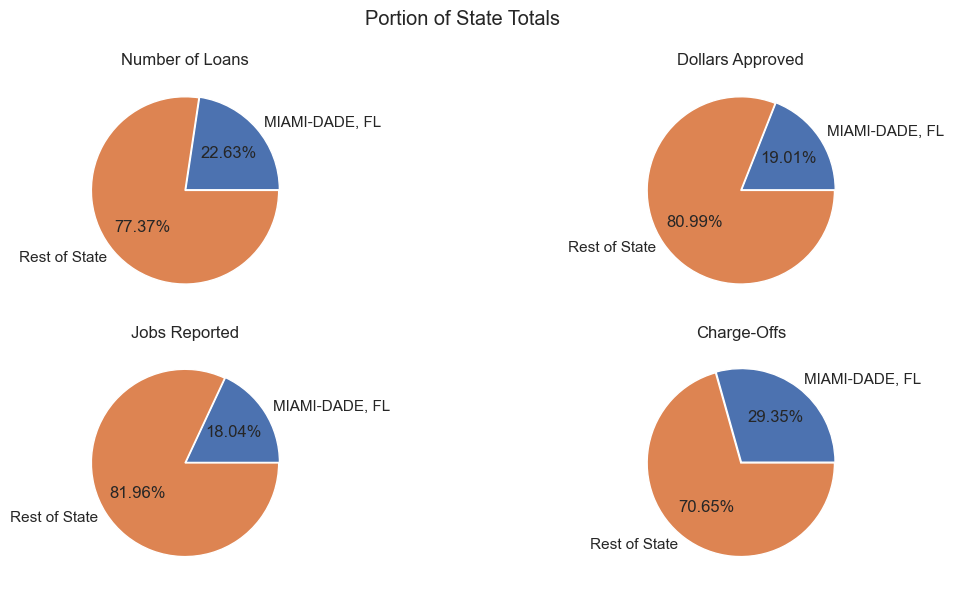

In [208]:
# In this cell we display the pie charts of the stats saved in rows_to_plot.

sns.set_theme()
# We create a function which will make a pie chart
def plot_pie(stats,fig, axs):
    """Takes a list of indices (of the dataframe key_facts), a matplotlib figure, and a list of flattened axes,
    then produces a set of pie charts (one for each index).  Make sure the length of the lists stats and axs match."""
    # We want to iterate through the indices and the axes simultaneously, so we zip them together.
    for (stat,ax) in zip(stats,axs):
        # We create a pie chart at each axis of the target county versus the rest of the state (so the two together represent
        # the state total)
        ax.pie([key_facts['{}, {}'.format(target_county,target_state)].loc[stat],
            key_facts['Rest of State'].loc[stat]],
            labels=['{}, {}'.format(target_county,target_state),'Rest of State'],
            colors=sns.color_palette(), 
            autopct='%.2f%%',
            explode=[.01,0])
        ax.set_title(stat)

# We need different behavior depending on how long the list of indices is, and whether we want to save the figure at all.
# If we want to save the figure, we first consider if only one stat is greater than 1% of the state total.
if files_to_save['percent of state pie'] and len(rows_to_plot)==1:
    # Create a figure and a single axis.
    fig, axs = plt.subplots(1,1,figsize=(6,3))
    # We need to flatten the axes just in case, since plot_pie expects a list.
    axs=axs.flatten()
    fig.suptitle('Portion of State Total')
    plot_pie(rows_to_plot,fig=fig,axs=axs)
    plt.tight_layout()
    plt.savefig(file_path+'state_total_pie_chart.png')
    plt.show()
elif files_to_save['percent of state pie'] and len(rows_to_plot)>1:
    # If there is more than one index which is over 1%, we break the cases down further when creating the figure and axes.
    if len(rows_to_plot)==2:
        fig, axs = plt.subplots(1,2,figsize=(6,6))
    elif len(rows_to_plot)==3:
        fig, axs = plt.subplots(2,2,figsize=(12,6))
        # We only want three axes so we delete the lower right one.
        fig.delaxes(axs[1,1])
    elif len(rows_to_plot)==4:
        fig, axs = plt.subplots(2,2,figsize=(12,6))
    # In any case we now want to flatten the axes so we can call plot_pie()
    axs=axs.flatten()
    fig.suptitle('Portion of State Totals')
    plot_pie(rows_to_plot,fig=fig,axs=axs)
    plt.tight_layout()
    plt.savefig(file_path+'state_totals_pie_charts.png')
    plt.show()


### City Stats
We store some key facts on the cities inside the target county.

In [209]:
# Gathering City Stats
# We want to combine the number of loans per city and the number of loan dollars per city.  We convert the cities to capital case to
# try and avoid counting loans separately if they were originally listed in different case styles.
city_df=pd.concat([
    target_df['ProjectCity'].str.upper().value_counts().rename('{} Loans'.format(target_county)),
    target_df.groupby(target_df['ProjectCity'].str.upper())['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county))
],axis=1)
# We now add what percent of the county total each city represents in these two areas.
city_df['{} Loan Percent'.format(target_county)]=(city_df['{} Loans'.format(target_county)]/target_county_loans)
city_df['{} Loan Dollars Percent'.format(target_county)]=(city_df['{} Loan Dollars'.format(target_county)]/target_county_loan_dollars)
city_df


,MIAMI-DADE Loans,MIAMI-DADE Loan Dollars,MIAMI-DADE Loan Percent,MIAMI-DADE Loan Dollars Percent
ProjectCity,,,,
MIAMI,120346,5.489191e+09,0.540762,5.697247e-01
HIALEAH,26378,7.372205e+08,0.118527,7.651633e-02
DORAL,11890,5.904010e+08,0.053426,6.127789e-02
HOMESTEAD,9838,2.539410e+08,0.044206,2.635661e-02
MIAMI BEACH,7677,4.867588e+08,0.034496,5.052084e-02
...,...,...,...,...
NORTH BAY VILAGE,1,2.083200e+04,0.000004,2.162159e-06
1850 NW 184 ST,1,2.083200e+04,0.000004,2.162159e-06
"MIAMI BEACH, FL 33139",1,2.083200e+04,0.000004,2.162159e-06


In [210]:
# Displaying city totals in a scatterplot.

# We only want to save the scatterplot of cities if the option has been checked at the start of this section.
if files_to_save['cities scatterplot']:
    # We will use a plotly scatterplot so that we can hover over datapoints for more information. On the x axis we will note the 
    # number of loans per city, and on the y axis the number of loan dollars (only loans and loan dollars listed in the county).
    fig=px.scatter(
        data_frame=city_df,
        x='{} Loans'.format(target_county),
        y='{} Loan Dollars'.format(target_county),
        title='Cities in {}, {}'.format(target_county,target_state),
        hover_name=city_df.index,
        template='seaborn',
        labels={ # For each source of data we have used, include 'source_name': 'Desired Name'
            '{} Loans'.format(target_county):'Loans',
            '{} Loan Dollars'.format(target_county): 'Loan Dollars',
    
        }
    )
    # We want to include dollar signs on the y values.
    fig.update_layout(yaxis_tickprefix = '$')
    # We save the figure appropriately.
    fig.write_html(file_path+'cities.html')
    fig.show()

### Counties Map
We create a choropleth map of the target state so we can compare county facts (with the target county highlighted).

In [211]:
if files_to_save['counties map']:
    # We need to obtain the state number from our dictionary for the target state and make sure our selected map only has features
    # for that target state.
    ####################
    selected_state_number=state_numbers_dictionary[target_state]
    selected_map['features'] = [f for f in county_map['features'] if f['properties']['STATE'] == selected_state_number]
    ####################
    # We select a dataframe to make a choropleth from.  We want county information in the target state, so we cut the county_totals
    # frame to include only those counties in the target state.
    graphable_df=county_totals[county_totals['State']==target_state]

    # We now create the choropleth.
    fig=px.choropleth(graphable_df,
                    geojson=selected_map,
                    locations=graphable_df.index, # Recall county_totals is indexed by FIPS codes (originally a string before becoming the index).
                    color='Dollars Approved', # We will let the number of loan dollars determine the color of each county.
                    hover_name='County', # The header of the hover text will be the county name.
                    hover_data=['Number of Loans'], # The additional data we want in the hoverbox.
                    color_continuous_scale="Viridis",
                    scope='usa',
                    labels={ # For each source of data you have used, include 'source_name': 'Desired Name'.
            'Number of Loans':'Loans',
            'Dollars Approved': 'Loan Dollars',
        })
    # The following sets the plot to zoom in on our target state.
    fig.update_geos(fitbounds="locations",visible=False)
    # We add borders around the state in black.  
    state_borders = go.Choropleth(
            locationmode='USA-states',
            z=[0,0,0,0,0,0,0,0,0,0,0,0],
            locations=[target_state],
            colorscale = [[0,'rgba(0, 0, 0, 0)'],[1,'rgba(0, 0, 0, 0)']],
            marker_line_color='Black',
            showscale = False,
            hoverinfo='skip' # We do not want to block or edit our present hover information.
        )
    # We also want a border around the chosen county to make it obvious.
    county_border= go.Choropleth(
            geojson=selected_map,
            z=[0,0,0,0,0,0,0,0,0,0,0,0],
            locations=[target_fips],
            colorscale = [[0,'rgba(0, 0, 0, 0)'],[1,'rgba(0, 0, 0, 0)']],
            marker_line_color='red',
            showscale = False,
            hoverinfo='skip'
        )

    # When creating this it is useful to view the hover template and then update traces.
    # Checking the hover template.
    #print(fig.data[0].hovertemplate)

    # Adjusting the template to reorder and remove the FIPS code.
    fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>Loans: %{customdata[0]} <br>Loan Dollars: $%{z}') 

    fig.add_trace(state_borders)
    fig.add_trace(county_border)
    fig.write_html(file_path+"counties_map.html")
    fig.show()

## Demographic Stats
In this section we store information on various demographic stats (gender, race, ethnicity).

In [212]:
# We will create a function to add percentage columns to a given dataframe.
# We will add columns representing what percent of the respective total each row represents.
# For example, given the gender dataframe, the 'Male Owned' row of the U.S. Loan Percent gives the percent of all loans in the U.S. 
# which were given as male owned. Likewise the 'Male Owned' row of Rest of State Loan Dollars Percent gives the percent of all loan dollars in 
# the target state (but not the target county) which went to male owned businesses.
def add_percent_columns(dataframe):
    """Accepts a dataframe with target_county, Rest of State, and U.S. Loans and Loan Dollars as columns, then creates additional columns
    representing what percent of the U.S. total each stat represents.  Two columns representing the different in percent between the
    target county and the rest of the state are also added."""
    dataframe['{} Loan Percent'.format(target_county)]=(dataframe['{} Loans'.format(target_county)]/target_county_loans)
    dataframe['{} Loan Dollars Percent'.format(target_county)]=(dataframe['{} Loan Dollars'.format(target_county)]/target_county_loan_dollars)
    dataframe['Rest of State Loan Percent']=(dataframe['Rest of State Loans']/outside_loans)
    dataframe['Rest of State Loan Dollars Percent']=(dataframe['Rest of State Loan Dollars']/outside_loan_dollars)
    dataframe['U.S. Loan Percent']=(dataframe['U.S. Loans']/national_loans)
    dataframe['U.S. Loan Dollars Percent']=(dataframe['U.S. Loan Dollars']/national_approved)
    # We will add columns to locate outliers from the rest of the state.
    dataframe['Loan Outliers']=abs(dataframe['{} Loan Percent'.format(target_county)]-dataframe['Rest of State Loan Percent'])
    dataframe['Loan Dollars Outliers']=abs(dataframe['{} Loan Dollars Percent'.format(target_county)]-dataframe['Rest of State Loan Dollars Percent'])
    return dataframe
    

In [213]:
# Gathering Gender stats
gender_df=pd.concat([
    national_gender,
    target_df['Gender'].value_counts().rename('{} Loans'.format(target_county)),
    target_df.groupby('Gender')['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df['Gender'].value_counts().rename('Rest of State Loans'),
    outside_df.groupby('Gender')['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars')    
],axis='columns')

# We fill all nan values with 0 then apply our custom function.
gender_df.fillna(0,inplace=True)
gender_df=add_percent_columns(gender_df)
gender_df.sort_index(inplace=True)
gender_df

,U.S. Loans,U.S. Loan Dollars,MIAMI-DADE Loans,MIAMI-DADE Loan Dollars,Rest of State Loans,Rest of State Loan Dollars,MIAMI-DADE Loan Percent,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Percent,Rest of State Loan Dollars Percent,U.S. Loan Percent,U.S. Loan Dollars Percent,Loan Outliers,Loan Dollars Outliers
Gender,,,,,,,,,,,,,,
Female Owned,1536339,6.368643e+10,27268,7.996357e+08,98114,3.305036e+09,0.122526,0.082994,0.128965,0.080539,0.133965,0.079925,0.006439,0.002455
Male Owned,2990883,2.412541e+11,47252,2.550713e+09,161134,1.070224e+10,0.212322,0.264739,0.211801,0.260799,0.260798,0.302768,0.000521,0.003940
Unanswered,6940988,4.918875e+11,148029,6.284465e+09,501532,2.702904e+10,0.665152,0.652266,0.659234,0.658661,0.605237,0.617307,0.005918,0.006395


In [214]:
# Gathering statistics by race.  Here we want a multi-index.
race_df=pd.concat([
    national_race,
    target_df.groupby(['Race','Gender']).size().rename('{} Loans'.format(target_county)),
    target_df.groupby(['Race','Gender'])['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df.groupby(['Race','Gender']).size().rename('Rest of State Loans'),
    outside_df.groupby(['Race','Gender'])['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars'),
],axis='columns')
# We fill blanks with 0
race_df.fillna(0,inplace=True)

# We would like to have totals for each race. 
# Each index in race_df.index is a list of two elements (the first and second level label).
# We want to iterate through the first level indices
for index in {i[0] for i in race_df.index}:
    # A warning is thrown after a certain number of iterations if we don't sort here.
    race_df.sort_index(inplace=True)
    # We want to create a second level label for each first level label representing the _TOTAL_ across all genders.
    race_df.loc[(index,'_TOTAL_'),:]=race_df.loc[(index,),:].sum()

# We can now sort the index completely (the underscore before TOTAL will make sure it comes last among the second level labels)
race_df.sort_index(inplace=True)    
# With the correct number of rows we can now add the additional columns.
race_df=add_percent_columns(race_df)
race_df


U.S. Loans  \
Race                                      Gender                     
American Indian or Alaska Native          Female Owned     25529.0   
                                          Male Owned       48609.0   
                                          Unanswered       11079.0   
                                          _TOTAL_          85217.0   
Asian                                     Female Owned     99769.0   
                                          Male Owned      191584.0   
                                          Unanswered       19239.0   
                                          _TOTAL_         310592.0   
Black or African American                 Female Owned    416952.0   
                                          Male Owned      387387.0   
                                          Unanswered       19941.0   
                                          _TOTAL_         824280.0   
Eskimo & Aleut                            Female Owned         3.0   
                                          Male Owned          16.0   
                                          Unanswered           2.0   
                                          _TOTAL_             21.0   
Multi Group                               Female Owned         4.0   
                                          Male Owned          41.0   
                                          Unanswered           8.0   
                                          _TOTAL_             53.0   
Native Hawaiian or Other Pacific Islander Female Owned      4199.0   
                                          Male Owned        5844.0   
                                          Unanswered         533.0   
                                          _TOTAL_          10576.0   
Puerto Rican                              Female Owned       111.0   
                                          Male Owned         446.0   
                                          Unanswered          90.0   
                                          _TOTAL_            647.0   
Unanswered                                Female Owned    532039.0   
                                          Male Owned     1253741.0   
                                          Unanswered     6843882.0   
                                          _TOTAL_        8629662.0   
White                                     Female Owned    457733.0   
                                          Male Owned     1103215.0   
                                          Unanswered       46214.0   
                                          _TOTAL_        1607162.0   

                                                        U.S. Loan Dollars  \
Race                                      Gender                            
American Indian or Alaska Native          Female Owned       9.587653e+08   
                                          Male Owned         3.019735e+09   
                                          Unanswered         8.835655e+08   
                                          _TOTAL_            4.862065e+09   
Asian                                     Female Owned       4.637592e+09   
                                          Male Owned         1.218616e+10   
                                          Unanswered         1.217498e+09   
                                          _TOTAL_            1.804125e+10   
Black or African American                 Female Owned       8.129774e+09   
                                          Male Owned         9.573680e+09   
                                          Unanswered         6.330800e+08   
                                          _TOTAL_            1.833653e+10   
Eskimo & Aleut                            Female Owned       3.746400e+04   
                                          Male Owned         7.146417e+05   
                                          Unanswered         5.365073e+04   
                                          _TOTAL_            8.057564e+05   
Multi Gro

In [215]:
# Gathering ethnicity stats.  
# Again, we want to use a multi-index.  We use the same approach as the previous cell (see above for details).
ethnicity_df=pd.concat([
    national_ethnicity,
    target_df.groupby(['Ethnicity','Gender']).size().rename('{} Loans'.format(target_county)),
    target_df.groupby(['Ethnicity','Gender'])['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df.groupby(['Ethnicity','Gender']).size().rename('Rest of State Loans'),
    outside_df.groupby(['Ethnicity','Gender'])['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars'),
],axis='columns')
ethnicity_df.fillna(0,inplace=True)

for index in {i[0] for i in ethnicity_df.index}:
    ethnicity_df.sort_index(inplace=True)
    ethnicity_df.loc[(index,'_TOTAL_'),:]=ethnicity_df.loc[(index,),:].sum()
ethnicity_df.sort_index(inplace=True)
ethnicity_df=add_percent_columns(ethnicity_df)
ethnicity_df

U.S. Loans  U.S. Loan Dollars  \
Ethnicity              Gender                                        
Hispanic or Latino     Female Owned    131500.0       4.731978e+09   
                       Male Owned      229579.0       1.318145e+10   
                       Unanswered       10200.0       7.621162e+08   
                       _TOTAL_         371279.0       1.867554e+10   
Not Hispanic or Latino Female Owned   1012823.0       4.176069e+10   
                       Male Owned     1869123.0       1.428170e+11   
                       Unanswered       67892.0       7.015714e+09   
                       _TOTAL_        2949838.0       1.915934e+11   
Unknown/NotStated      Female Owned    392016.0       1.719377e+10   
                       Male Owned      892181.0       8.525562e+10   
                       Unanswered     6862896.0       4.841097e+11   
                       _TOTAL_        8147093.0       5.865590e+11   

                                     MIAMI-DADE Loans  \
Ethnicity              Gender                           
Hispanic or Latino     Female Owned           13746.0   
                       Male Owned             23103.0   
                       Unanswered               741.0   
                       _TOTAL_                37590.0   
Not Hispanic or Latino Female Owned            5792.0   
                       Male Owned              9597.0   
                       Unanswered               539.0   
                       _TOTAL_                15928.0   
Unknown/NotStated      Female Owned            7730.0   
                       Male Owned             14552.0   
                       Unanswered            146749.0   
                       _TOTAL_               169031.0   

                                     MIAMI-DADE Loan Dollars  \
Ethnicity              Gender                                  
Hispanic or Latino     Female Owned             4.156106e+08   
                       Male Owned               1.192665e+09   
                       Unanswered               5.429743e+07   
                       _TOTAL_                  1.662573e+09   
Not Hispanic or Latino Female Owned             1.946364e+08   
                       Male Owned               5.637346e+08   
                       Unanswered               3.972420e+07   
                       _TOTAL_                  7.980952e+08   
Unknown/NotStated      Female Owned             1.893887e+08   
                       Male Owned               7.943135e+08   
                       Unanswered               6.190443e+09   
                       _TOTAL_                  7.174145e+09   

                                     Rest of State Loans  \
Ethnicity              Gender                              
Hispanic or Latino     Female Owned              13923.0   
                       Male Owned                20930.0   
                       Unanswered                  822.0   
                       _TOTAL_                   35675.0   
Not Hispanic or Latino Female Owned              56475.0   
                       Male Owned                86891.0   
                       Unanswered                 5231.0   
                       _TOTAL_                  148597.0   
Unknown/NotStated      Female Owned              27716.0   
                       Male Owned                53313.0   
                       Unanswered               495479.0   
                       _TOTAL_                  576508.0   

                                     Rest of State Loan Dollars  \
Ethnicity              Gender                                     
Hispanic or Latino     Female Owned                3.915780e+08   
                       Male Owned                  8.693448e+08   
                       Unanswered                  4.177813e+07   
                       _TOTAL_                     1.302701e+09   
Not Hispanic or Latino Female Owned                1.987997e+09   
                       Male Owned                 

## NAICs/Business Stats
We collect stats for business sizes, NAICs sectors, and NAICs codes.

In [216]:
# Job bins
job_bins_df=pd.concat([
    national_job_bins,
    target_df['JobsReportedBins'].value_counts().rename('{} Loans'.format(target_county)),
    target_df.groupby('JobsReportedBins',observed=True)['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df['JobsReportedBins'].value_counts().rename('Rest of State Loans'),
    outside_df.groupby('JobsReportedBins',observed=True)['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars')    
],axis='columns')
job_bins_df.fillna(0,inplace=True)
job_bins_df=add_percent_columns(job_bins_df)
job_bins_df

,U.S. Loans,U.S. Loan Dollars,MIAMI-DADE Loans,MIAMI-DADE Loan Dollars,Rest of State Loans,Rest of State Loan Dollars,MIAMI-DADE Loan Percent,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Percent,Rest of State Loan Dollars Percent,U.S. Loan Percent,U.S. Loan Dollars Percent,Loan Outliers,Loan Dollars Outliers
JobsReportedBins,,,,,,,,,,,,,,
1,6023602,7.914621e+10,149881,1.853659e+09,427792,5.307478e+09,0.673474,0.192392,0.562307,0.129336,0.525243,0.099327,0.111167,0.063056
2-10,3732418,1.471270e+11,53907,2.130398e+09,237071,8.718072e+09,0.242225,0.221115,0.311616,0.212448,0.325458,0.184641,0.069390,0.008667
11-50,1422966,2.644233e+11,15776,2.856330e+09,81401,1.366899e+10,0.070888,0.296459,0.106997,0.333095,0.124079,0.331845,0.036109,0.036636
51-250,262442,2.285302e+11,2696,2.063335e+09,13276,1.015551e+10,0.012114,0.214154,0.017451,0.247476,0.022884,0.286800,0.005336,0.033322
250+,26773,7.760061e+10,289,7.310917e+08,1240,3.186273e+09,0.001299,0.075880,0.001630,0.077645,0.002335,0.097387,0.000331,0.001765


In [217]:
# Naics Sector
naics_sector_df=pd.concat([
    national_naics_sector, 
    target_df['NAICSSector'].value_counts().rename('{} Loans'.format(target_county)),
    target_df.groupby('NAICSSector')['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df['NAICSSector'].value_counts().rename('Rest of State Loans'),
    outside_df.groupby('NAICSSector')['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars')    
],axis='columns')

# We fill all nan values with 0 then apply our custom function.
naics_sector_df.fillna(0,inplace=True)
naics_sector_df=add_percent_columns(naics_sector_df)
naics_sector_df.sort_index(inplace=True)
naics_sector_df

,U.S. Loans,U.S. Loan Dollars,MIAMI-DADE Loans,MIAMI-DADE Loan Dollars,Rest of State Loans,Rest of State Loan Dollars,MIAMI-DADE Loan Percent,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Percent,Rest of State Loan Dollars Percent,U.S. Loan Percent,U.S. Loan Dollars Percent,Loan Outliers,Loan Dollars Outliers
NAICSSector,,,,,,,,,,,,,,
Accommodation and Food Services,819073,8.348950e+10,11785,1.219564e+09,48582,4.838045e+09,0.052955,0.126579,0.063858,0.117897,0.071421,0.104777,0.010904,0.008682
Administrative and Support and Waste Management and Remediation Services,619640,3.915683e+10,17081,5.084710e+08,56089,2.416135e+09,0.076752,0.052774,0.073726,0.058878,0.054031,0.049141,0.003026,0.006104
"Agriculture, Forestry, Fishing and Hunting",677280,1.800570e+10,912,6.880714e+07,6850,4.414533e+08,0.004098,0.007142,0.009004,0.010758,0.059057,0.022597,0.004906,0.003616
"Arts, Entertainment, and Recreation",339762,1.539533e+10,5350,1.696335e+08,21485,9.164091e+08,0.024040,0.017606,0.028241,0.022332,0.029626,0.019321,0.004201,0.004725
Construction,1021257,9.817771e+10,18589,9.026596e+08,70325,5.270451e+09,0.083528,0.093687,0.092438,0.128434,0.089051,0.123211,0.008910,0.034746
Educational Services,183896,1.713935e+10,3192,2.417359e+08,12493,7.909987e+08,0.014343,0.025090,0.016421,0.019276,0.016035,0.021509,0.002078,0.005814
Finance and Insurance,299301,1.549301e+10,6403,2.588194e+08,22570,1.028989e+09,0.028771,0.026863,0.029667,0.025075,0.026098,0.019443,0.000896,0.001788
Health Care and Social Assistance,992996,9.656239e+10,17709,9.121262e+08,66545,5.134947e+09,0.079573,0.094670,0.087469,0.125132,0.086587,0.121183,0.007896,0.030462
Information,144241,1.334582e+10,2313,1.201320e+08,8836,6.244220e+08,0.010393,0.012469,0.011614,0.015216,0.012577,0.016749,0.001221,0.002748


In [218]:
# Naics Code (no national values needed.  We will only use this for outliers)
naics_code_df=pd.concat([
    target_df['NAICSCode'].value_counts().rename('{} Loans'.format(target_county)),
    target_df.groupby('NAICSCode')['InitialApprovalAmount'].sum().rename('{} Loan Dollars'.format(target_county)),
    outside_df['NAICSCode'].value_counts().rename('Rest of State Loans'),
    outside_df.groupby('NAICSCode')['InitialApprovalAmount'].sum().rename('Rest of State Loan Dollars')    
],axis='columns')

# We fill all nan values with 0 then continue
naics_code_df.fillna(0,inplace=True)

# Because this dataframe does not have U.S. level information, we will have to manually put together the same kinds of columns as in
# the function add_percent_columns().
naics_code_df['{} Loan Percent'.format(target_county)]=(naics_code_df['{} Loans'.format(target_county)]/target_county_loans)
naics_code_df['{} Loan Dollars Percent'.format(target_county)]=(naics_code_df['{} Loan Dollars'.format(target_county)]/target_county_loan_dollars)
naics_code_df['Rest of State Loan Percent']=(naics_code_df['Rest of State Loans']/outside_loans)
naics_code_df['Rest of State Loan Dollars Percent']=(naics_code_df['Rest of State Loan Dollars']/outside_loan_dollars)
# We will add column to locate outliers from the rest of the state.
naics_code_df['Loan Outliers']=abs(naics_code_df['{} Loan Percent'.format(target_county)]-naics_code_df['Rest of State Loan Percent'])
naics_code_df['Loan Dollars Outliers']=abs(naics_code_df['{} Loan Dollars Percent'.format(target_county)]-naics_code_df['Rest of State Loan Dollars Percent'])
naics_code_df.index=[str(i).split('.', 1)[0] for i in naics_code_df.index]
naics_code_df

,MIAMI-DADE Loans,MIAMI-DADE Loan Dollars,Rest of State Loans,Rest of State Loan Dollars,MIAMI-DADE Loan Percent,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Percent,Rest of State Loan Dollars Percent,Loan Outliers,Loan Dollars Outliers
485310,12870.0,1.310371e+08,21574.0,2.351939e+08,0.057830,0.013600,0.028358,5.731359e-03,0.029472,7.869016e-03
812990,9809.0,2.310202e+08,25810.0,6.309725e+08,0.044076,0.023978,0.033926,1.537595e-02,0.010150,8.601702e-03
484110,6559.0,1.552099e+08,12181.0,3.370877e+08,0.029472,0.016109,0.016011,8.214374e-03,0.013461,7.894905e-03
812112,6373.0,1.078453e+08,27997.0,5.134496e+08,0.028636,0.011193,0.036800,1.251208e-02,0.008164,1.318779e-03
561720,5205.0,7.944468e+07,15190.0,2.956063e+08,0.023388,0.008246,0.019966,7.203528e-03,0.003422,1.042058e-03
...,...,...,...,...,...,...,...,...,...,...
331422,0.0,0.000000e+00,1.0,3.320000e+04,0.000000,0.000000,0.000001,8.090393e-07,0.000001,8.090393e-07
311221,0.0,0.000000e+00,1.0,1.600000e+06,0.000000,0.000000,0.000001,3.898985e-05,0.000001,3.898985e-05
325191,0.0,0.000000e+00,1.0,2.945000e+04,0.000000,0.000000,0.000001,7.176569e-07,0.000001,7.176569e-07
314121,0.0,0.000000e+00,1.0,2.850500e+04,0.000000,0.000000,0.000001,6.946285e-07,0.000001,6.946285e-07


## Descriptive Stats
We will prepare descriptive stats (min, max, quartiles, standard deviation, etc) at two levels.  First counting the totals for each county as the instances, and then by using each individual loan.

### County Level
We would like to put together boxplots for the different county level descriptive stats.  Using Seaborn it is often easiest to create multiple boxes by making each box represent a column in the same dataframe.  In particular our goal will be to have two boxes per plot-- one to represent the descriptive stats when all counties in the U.S. are considered, and another restricted to the target state.  The set of counties in the target state is obviously smaller (and will take less rows) but we populate the other rows with NaN values.  Seaborn will ignore NaN entries when building the boxplots.

In [219]:
# We need to have a dataframe with every county in the U.S. as rows, but then additional columns in which the only rows with non-null entries 
# lie in the target state.
in_state_columns = [county_totals[county_totals['State']==target_state][column].rename('In-State '+column)
                     for column in county_totals.drop(columns=['State','County']).columns]
county_level_boxplots=pd.concat([county_totals]+in_state_columns,axis=1)
county_level_boxplots

,State,County,Number of Loans,Dollars Approved,Jobs Reported,Charge-Offs,Charge-Off Rate,In-State Number of Loans,In-State Dollars Approved,In-State Jobs Reported,In-State Charge-Offs,In-State Charge-Off Rate
FIPS,,,,,,,,,,,,
02013,AK,ALEUTIANS EAST,109,4.885950e+06,441.0,2.0,0.018349,NaN,NaN,NaN,NaN,NaN
02016,AK,ALEUTIANS WEST,68,3.790478e+06,341.0,3.0,0.044118,NaN,NaN,NaN,NaN,NaN
02020,AK,ANCHORAGE,9046,1.062704e+09,98560.0,189.0,0.020893,NaN,NaN,NaN,NaN,NaN
02050,AK,BETHEL,77,5.566367e+06,644.0,2.0,0.025974,NaN,NaN,NaN,NaN,NaN
02060,AK,BRISTOL BAY,81,5.639726e+06,528.0,1.0,0.012346,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,SWEETWATER,1131,9.874333e+07,9090.0,25.0,0.022104,NaN,NaN,NaN,NaN,NaN
56039,WY,TETON,2233,1.808671e+08,19806.0,23.0,0.010300,NaN,NaN,NaN,NaN,NaN
56041,WY,UINTA,587,5.460333e+07,5763.0,11.0,0.018739,NaN,NaN,NaN,NaN,NaN


In [220]:
# Graphing will look better if we use thousands of dollars as our measurement.
county_level_boxplots['Dollars Approved (in thousands)']=county_level_boxplots['Dollars Approved']/1000
county_level_boxplots['In-State Dollars Approved (in thousands)']=county_level_boxplots['In-State Dollars Approved']/1000

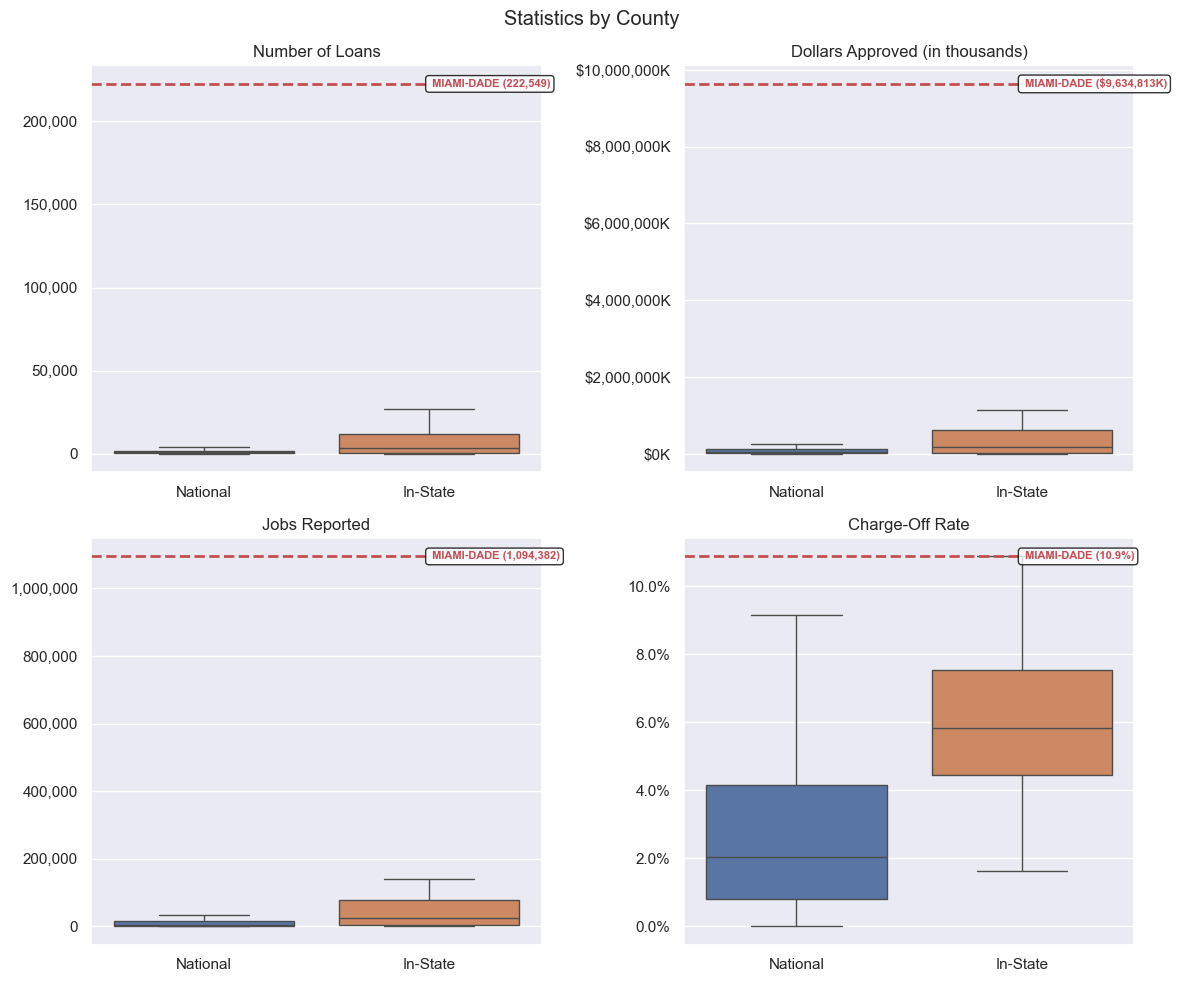

In [221]:
# We will only create and save the county level boxplots if the option was chosen earlier.
if files_to_save['county level boxplots']:
    sns.set_theme()
    # We want four plots in a two by two grid.
    fig, axs = plt.subplots(2,2,figsize=(12,10))
    axs=axs.flatten()
    # The first plot represents the number of loans per county (in the U.S. versus in the target state)
    sns.boxplot(data=county_level_boxplots[['Number of Loans','In-State Number of Loans']].rename(
        columns={'Number of Loans':'National','In-State Number of Loans':'In-State'}),
        showfliers=False, # We do not show fliers, so there could be large outliers.
        ax=axs[0])
    plt.suptitle('Statistics by County')
    # We will add a horizontal line indicating the number of loans in the target county.
    axs[0].axhline(y=county_totals.loc[target_fips]['Number of Loans'],
                xmin=0,
                xmax=.75,
                color=sns.color_palette()[3],
                lw=2,
                ls='--') 
    # We will also annotate the line appropriately.  
    text=axs[0].text(.75, county_totals.loc[target_fips]['Number of Loans'], 
            " "+county_totals.loc[target_fips]['County']+" ({0:,.0f})".format(county_totals.loc[target_fips]['Number of Loans']), 
            ha='left', 
            va='center',
            color=sns.color_palette()[3],
            fontsize=8,
            weight='bold',
            transform=axs[0].get_yaxis_transform())
    # We set a bbox for the annotation.
    text.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=.8))
    axs[0].title.set_text('Number of Loans')
    # Finally we format the y axis.
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    axs[0].yaxis.set_major_formatter(tick) 


    # We repeat the process for the dollars approved, jobs reported, and charge-off rate.  The key difference is changing the y-axis format.
    sns.boxplot(data=county_level_boxplots[['Dollars Approved (in thousands)','In-State Dollars Approved (in thousands)']].rename(
        columns={'Dollars Approved (in thousands)':'National','In-State Dollars Approved (in thousands)':'In-State'}),
        showfliers=False,
        ax=axs[1])

    axs[1].axhline(y=county_totals.loc[target_fips]['Dollars Approved']/1000,
                xmin=0,
                xmax=.75,
                color=sns.color_palette()[3],
                lw=2,
                ls='--') 
    text=axs[1].text(.75, county_totals.loc[target_fips]['Dollars Approved']/1000, 
            " "+county_totals.loc[target_fips]['County']+" (${0:,.0f}K)".format(round(county_totals.loc[target_fips]['Dollars Approved']/1000)), 
            ha='left', 
            va='center',
            color=sns.color_palette()[3],
            fontsize=8,
            weight='bold',
            transform=axs[1].get_yaxis_transform())
    text.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=.8))
    axs[1].title.set_text('Dollars Approved (in thousands)')
    fmt = '${x:,.0f}K'
    tick = mtick.StrMethodFormatter(fmt)
    axs[1].yaxis.set_major_formatter(tick) 



    sns.boxplot(data=county_level_boxplots[['Jobs Reported','In-State Jobs Reported']].rename(
        columns={'Jobs Reported':'National','In-State Jobs Reported':'In-State'}),
        showfliers=False,
        ax=axs[2])

    axs[2].axhline(y=county_totals.loc[target_fips]['Jobs Reported'],
                xmin=0,
                xmax=.75,
                color=sns.color_palette()[3],
                lw=2,
                ls='--') 
    text=axs[2].text(.75, county_totals.loc[target_fips]['Jobs Reported'], 
            " "+county_totals.loc[target_fips]['County']+" ({0:,.0f})".format(county_totals.loc[target_fips]['Jobs Reported']), 
            ha='left', 
            va='center',
            color=sns.color_palette()[3],
            fontsize=8,
            weight='bold',
            transform=axs[2].get_yaxis_transform())
    text.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=.8))
    axs[2].title.set_text('Jobs Reported')
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    axs[2].yaxis.set_major_formatter(tick) 


    sns.boxplot(data=county_level_boxplots[['Charge-Off Rate','In-State Charge-Off Rate']].rename(
        columns={'Charge-Off Rate':'National','In-State Charge-Off Rate':'In-State'}),
        showfliers=False,
        ax=axs[3])

    axs[3].axhline(y=county_totals.loc[target_fips]['Charge-Off Rate'],
                xmin=0,
                xmax=.75,
                color=sns.color_palette()[3],
                lw=2,
                ls='--') 
    text=axs[3].text(.75, county_totals.loc[target_fips]['Charge-Off Rate'], 
            " "+county_totals.loc[target_fips]['County']+" ({:.1%})".format(county_totals.loc[target_fips]['Charge-Off Rate']), 
            ha='left', 
            va='center',
            color=sns.color_palette()[3],
            fontsize=8,
            weight='bold',
            transform=axs[3].get_yaxis_transform())
    text.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=.8))
    axs[3].title.set_text('Charge-Off Rate')
    axs[3].yaxis.set_major_formatter(mtick.PercentFormatter(1)) 

    plt.tight_layout()
    plt.savefig(file_path+'county_level_boxplots.png')
    plt.show()

### Loan Level
At the loan level using Seaborn right away can take too long.  Instead we will strip the key stats from pandas.describe() and feed the quartiles into a Seaborn boxplot.  We will consider the number of dollars approved and the number of jobs per loan in the U.S., in the target state, and in the target county.

In [222]:
loan_level_dollars=pd.concat([
    df['InitialApprovalAmount'].describe().rename('National'),
    df[df['ProjectState']==target_state]['InitialApprovalAmount'].describe().rename('In-State'),
    target_df['InitialApprovalAmount'].describe().rename(target_county+', '+target_state),
], axis=1)
loan_level_dollars

,National,In-State,"MIAMI-DADE, FL"
count,1.146821e+07,9.833290e+05,2.225490e+05
mean,6.948146e+04,5.153020e+04,4.329300e+04
std,2.603667e+05,1.949506e+05,1.754878e+05
min,-1.996590e+05,1.000000e+00,3.000000e+00
25%,9.562000e+03,7.500000e+03,6.308000e+03
50%,2.069700e+04,1.913200e+04,1.769600e+04
75%,4.080000e+04,2.906100e+04,2.083300e+04
max,1.000000e+07,1.000000e+07,1.000000e+07


In [223]:
loan_level_jobs=pd.concat([
    df['JobsReported'].describe().rename('National'),
    df[df['ProjectState']==target_state]['JobsReported'].describe().rename('In-State'),
    target_df['JobsReported'].describe().rename(target_county+', '+target_state),
], axis=1)
loan_level_jobs

,National,In-State,"MIAMI-DADE, FL"
count,1.146820e+07,983329.000000,222549.000000
mean,7.834782e+00,6.167851,4.917488
std,2.509505e+01,20.743421,18.759261
min,-6.000000e+00,0.000000,1.000000
25%,1.000000e+00,1.000000,1.000000
50%,1.000000e+00,1.000000,1.000000
75%,6.000000e+00,4.000000,3.000000
max,5.000000e+02,500.000000,500.000000


In [224]:
# When creating our boxplots we want to match the format of a typical Seaborn plot which has whiskers which extend to 
# the largest value in the data which is within 1.5 times the interquartile range (the 75% percentile minus the 25%)
# of the 75% percentile.
loan_level_dollar_boxes=pd.DataFrame()
for column in loan_level_dollars.columns:
    iqr=(loan_level_dollars.loc['75%'][column]-loan_level_dollars.loc['25%'][column])
    loan_level_dollar_boxes[column]=(
        loan_level_dollars.iloc[4:7][column].to_list()+ # iloc[4:7] gives the quartiles (25%, 50%, 75%)
        [min(loan_level_dollars.loc['max'][column],1.5*iqr+loan_level_dollars.loc['75%'][column]-1)]+ # We subtract 1 to make sure the result in range of Seaborn
        [max(loan_level_dollars.loc['min'][column],loan_level_dollars.loc['25%'][column]+1-1.5*iqr,0)]
    )

loan_level_dollar_boxes=loan_level_dollar_boxes/1000
loan_level_dollar_boxes


,National,In-State,"MIAMI-DADE, FL"
0,9.562,7.5000,6.3080
1,20.697,19.1320,17.6960
2,40.800,29.0610,20.8330
3,87.656,61.4015,42.6195
4,0.000,0.0010,0.0030


In [225]:
loan_level_job_boxes=pd.DataFrame()
for column in loan_level_jobs.columns:
    iqr=(loan_level_jobs.loc['75%'][column]-loan_level_jobs.loc['25%'][column])
    loan_level_job_boxes[column]=(
        loan_level_jobs.iloc[4:7][column].to_list()+
        [min(loan_level_jobs.loc['max'][column],1.5*iqr+loan_level_jobs.loc['75%'][column])]+
        [max(loan_level_jobs.loc['min'][column],loan_level_jobs.loc['25%'][column]+-1.5*iqr,0)]
    )

loan_level_job_boxes

,National,In-State,"MIAMI-DADE, FL"
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,6.0,4.0,3.0
3,13.5,8.5,6.0
4,0.0,0.0,1.0


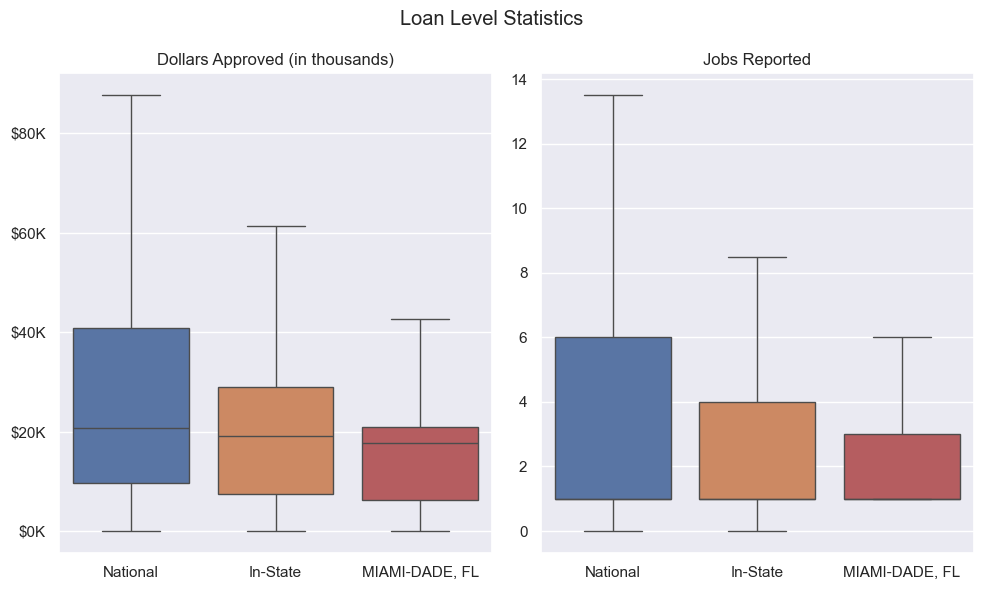

In [226]:
# Creating and saving loan level boxplots if the option was checked.
if files_to_save['loan level boxplots']:
    sns.set_theme()
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    axs=axs.flatten()
    sns.boxplot(data=loan_level_dollar_boxes,
                showfliers=False,
                palette=[sns.color_palette()[0],sns.color_palette()[1],sns.color_palette()[3]],
                ax=axs[0])
    axs[0].title.set_text('Dollars Approved (in thousands)')
    fmt = '${x:,.0f}K'
    tick = mtick.StrMethodFormatter(fmt)
    axs[0].yaxis.set_major_formatter(tick)

    sns.boxplot(data=loan_level_job_boxes,
                showfliers=False,
                palette=[sns.color_palette()[0],sns.color_palette()[1],sns.color_palette()[3]],
                ax=axs[1])

    axs[1].title.set_text('Jobs Reported')
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    axs[1].yaxis.set_major_formatter(tick) 
    plt.suptitle('Loan Level Statistics')
    plt.tight_layout()
    plt.savefig(file_path+'loan_level_boxplots.png')
    plt.show()

## Outliers Overview
We will create a dataframe consisting of the largest outliers for each demographic and business type based on loans,then one based on loan dollars.

In [227]:
# On loans
# We add a function which adds dictionaries to a list, where each dictionary represents a row in a dataframe we intend to make.
def add_loan_outliers(list,dataframe,category):
    """Takes a list, dataframe, and a category; then for each row of the top 10 rows (with respect to the loan outlier feature)
    adds a dictionary to the list of the form column_name:row_entry."""
    for index, row in dataframe.nlargest(n=10,columns='Loan Outliers').iterrows():
        list.append({
            'Outlier':row.name,
            'Category':category,
            '{} Loans'.format(target_county):row['{} Loans'.format(target_county)],
            '{} Loan Percent'.format(target_county):row['{} Loan Percent'.format(target_county)],
            'Rest of State Loans':row['Rest of State Loans'],
            'Rest of State Loan Percent':row['Rest of State Loan Percent'],
            '{} Loan Dollars'.format(target_county):row['{} Loan Dollars'.format(target_county)],
            '{} Loan Dollars Percent'.format(target_county):row['{} Loan Dollars Percent'.format(target_county)],
            'Rest of State Loan Dollars':row['Rest of State Loan Dollars'],
            'Rest of State Loan Dollars Percent':row['Rest of State Loan Dollars Percent'],
            'Loan Outliers':row['Loan Outliers']
            })
# We start a list.
outlier_loans_list=[]
# For various dataframes we have made we now add the top outliers to our list
add_loan_outliers(outlier_loans_list,gender_df.drop('Unanswered',axis=0),'Gender') # We won't count outliers for Unanswered.
add_loan_outliers(outlier_loans_list,race_df.drop('Unanswered',axis=0,level=0).drop('Unanswered',axis=0,level=1),'Race/Gender')
add_loan_outliers(outlier_loans_list,ethnicity_df.drop('Unknown/NotStated',axis=0,level=0).drop('Unanswered',axis=0,level=1),'Ethnicity/Gender')
add_loan_outliers(outlier_loans_list,job_bins_df,'Jobs Reported')
add_loan_outliers(outlier_loans_list,naics_sector_df,'NAICs Sector')
add_loan_outliers(outlier_loans_list,naics_code_df,'NAICs Code')
# We make a dataframe from this list.
outlier_loans_df=pd.DataFrame(outlier_loans_list)
outlier_loans_df.set_index('Outlier',inplace=True)
outlier_loans_df.sort_values(by='Loan Outliers', ascending=False,inplace=True)
outlier_loans_df

,Category,MIAMI-DADE Loans,MIAMI-DADE Loan Percent,Rest of State Loans,Rest of State Loan Percent,MIAMI-DADE Loan Dollars,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Dollars,Rest of State Loan Dollars Percent,Loan Outliers
Outlier,,,,,,,,,,
"(Not Hispanic or Latino, _TOTAL_)",Ethnicity/Gender,15928.0,0.071571,148597.0,0.195322,7.980952e+08,0.082835,8.357195e+09,0.203654,0.123751
"(Hispanic or Latino, _TOTAL_)",Ethnicity/Gender,37590.0,0.168907,35675.0,0.046893,1.662573e+09,0.172559,1.302701e+09,0.031745,0.122014
1,Jobs Reported,149881.0,0.673474,427792.0,0.562307,1.853659e+09,0.192392,5.307478e+09,0.129336,0.111167
"(Hispanic or Latino, Male Owned)",Ethnicity/Gender,23103.0,0.103811,20930.0,0.027511,1.192665e+09,0.123787,8.693448e+08,0.021185,0.076300
"(Not Hispanic or Latino, Male Owned)",Ethnicity/Gender,9597.0,0.043123,86891.0,0.114213,5.637346e+08,0.058510,5.981581e+09,0.145763,0.071090
2-10,Jobs Reported,53907.0,0.242225,237071.0,0.311616,2.130398e+09,0.221115,8.718072e+09,0.212448,0.069390
Transportation and Warehousing,NAICs Sector,36130.0,0.162346,73085.0,0.096066,7.914802e+08,0.082148,1.698601e+09,0.041393,0.066280
"(Not Hispanic or Latino, Female Owned)",Ethnicity/Gender,5792.0,0.026026,56475.0,0.074233,1.946364e+08,0.020201,1.987997e+09,0.048445,0.048207
"(Hispanic or Latino, Female Owned)",Ethnicity/Gender,13746.0,0.061766,13923.0,0.018301,4.156106e+08,0.043136,3.915780e+08,0.009542,0.043465


In [228]:
# On loan dollars:
# Repeating the technique from the previous cell, this time for loan dollar outliers.
def add_dollar_outliers(list,dataframe,category):
    for index, row in dataframe.nlargest(n=10,columns='Loan Dollars Outliers').iterrows():
        list.append({
            'Outlier':row.name,
            'Category':category,
            '{} Loans'.format(target_county):row['{} Loans'.format(target_county)],
            '{} Loan Percent'.format(target_county):row['{} Loan Percent'.format(target_county)],
            'Rest of State Loans':row['Rest of State Loans'],
            'Rest of State Loan Percent':row['Rest of State Loan Percent'],
            '{} Loan Dollars'.format(target_county):row['{} Loan Dollars'.format(target_county)],
            '{} Loan Dollars Percent'.format(target_county):row['{} Loan Dollars Percent'.format(target_county)],
            'Rest of State Loan Dollars':row['Rest of State Loan Dollars'],
            'Rest of State Loan Dollars Percent':row['Rest of State Loan Dollars Percent'],
            'Loan Dollars Outliers':row['Loan Dollars Outliers']
            })

outlier_dollars_list=[]
add_dollar_outliers(outlier_dollars_list,gender_df.drop('Unanswered',axis=0),'Gender')
add_dollar_outliers(outlier_dollars_list,race_df.drop('Unanswered',axis=0,level=0).drop('Unanswered',axis=0,level=1),'Race/Gender')
add_dollar_outliers(outlier_dollars_list,ethnicity_df.drop('Unknown/NotStated',axis=0,level=0).drop('Unanswered',axis=0,level=1),'Ethnicity/Gender')
add_dollar_outliers(outlier_dollars_list,job_bins_df,'Jobs Reported')
add_dollar_outliers(outlier_dollars_list,naics_sector_df,'NAICs Sector')
add_dollar_outliers(outlier_dollars_list,naics_code_df,'NAICs Code')
outlier_dollars_df=pd.DataFrame(outlier_dollars_list)
outlier_dollars_df.set_index('Outlier',inplace=True)
outlier_dollars_df.sort_values(by='Loan Dollars Outliers', ascending=False,inplace=True)
outlier_dollars_df

,Category,MIAMI-DADE Loans,MIAMI-DADE Loan Percent,Rest of State Loans,Rest of State Loan Percent,MIAMI-DADE Loan Dollars,MIAMI-DADE Loan Dollars Percent,Rest of State Loan Dollars,Rest of State Loan Dollars Percent,Loan Dollars Outliers
Outlier,,,,,,,,,,
"(Hispanic or Latino, _TOTAL_)",Ethnicity/Gender,37590.0,0.168907,35675.0,0.046893,1.662573e+09,0.172559,1.302701e+09,0.031745,0.140814
"(Not Hispanic or Latino, _TOTAL_)",Ethnicity/Gender,15928.0,0.071571,148597.0,0.195322,7.980952e+08,0.082835,8.357195e+09,0.203654,0.120819
"(Hispanic or Latino, Male Owned)",Ethnicity/Gender,23103.0,0.103811,20930.0,0.027511,1.192665e+09,0.123787,8.693448e+08,0.021185,0.102602
"(Not Hispanic or Latino, Male Owned)",Ethnicity/Gender,9597.0,0.043123,86891.0,0.114213,5.637346e+08,0.058510,5.981581e+09,0.145763,0.087253
1,Jobs Reported,149881.0,0.673474,427792.0,0.562307,1.853659e+09,0.192392,5.307478e+09,0.129336,0.063056
Transportation and Warehousing,NAICs Sector,36130.0,0.162346,73085.0,0.096066,7.914802e+08,0.082148,1.698601e+09,0.041393,0.040755
11-50,Jobs Reported,15776.0,0.070888,81401.0,0.106997,2.856330e+09,0.296459,1.366899e+10,0.333095,0.036636
Construction,NAICs Sector,18589.0,0.083528,70325.0,0.092438,9.026596e+08,0.093687,5.270451e+09,0.128434,0.034746
"(Hispanic or Latino, Female Owned)",Ethnicity/Gender,13746.0,0.061766,13923.0,0.018301,4.156106e+08,0.043136,3.915780e+08,0.009542,0.033594


## Saving The Excel Report

In [229]:
# For the demographic and business data we want to save only some of the columns.  We will store the following
columns_to_save=['{} Loans'.format(target_county),
                 '{} Loan Percent'.format(target_county),
                 '{} Loan Dollars'.format(target_county),
                 '{} Loan Dollars Percent'.format(target_county),
                 '{} Loans'.format('Rest of State'),
                 '{} Loan Percent'.format('Rest of State'),
                 '{} Loan Dollars'.format('Rest of State'),
                 '{} Loan Dollars Percent'.format('Rest of State'),
                 '{} Loans'.format('U.S.'),
                 '{} Loan Percent'.format('U.S.'),
                 '{} Loan Dollars'.format('U.S.'),
                 '{} Loan Dollars Percent'.format('U.S.')
        ]
columns_to_save

['MIAMI-DADE Loans',
 'MIAMI-DADE Loan Percent',
 'MIAMI-DADE Loan Dollars',
 'MIAMI-DADE Loan Dollars Percent',
 'Rest of State Loans',
 'Rest of State Loan Percent',
 'Rest of State Loan Dollars',
 'Rest of State Loan Dollars Percent',
 'U.S. Loans',
 'U.S. Loan Percent',
 'U.S. Loan Dollars',
 'U.S. Loan Dollars Percent']

In [230]:
# We conclude by saving various statistics to an excel file.
# Creating the file.
writer= pd.ExcelWriter(file_path+'county_report.xlsx', engine='xlsxwriter')
# Creating the formats we will use.
header_format = writer.book.add_format({'bold':True,'text_wrap': True})
number_format = writer.book.add_format({'num_format': '#,##'})
currency_format= writer.book.add_format({'num_format':'$#,##0.00'})
percent_format = writer.book.add_format({'num_format':'0.00%'})
wrap_format=writer.book.add_format({'text_wrap': True})


########################################################################################################
# Overview:
########################################################################################################
# We will create a sheet labeled 'Overview' which gives general details on the target county using information we gather in the
# key facts section of this notebook.
key_facts.to_excel(writer, sheet_name='Overview', startrow=0, startcol=0)
# We will convert all to number format then adjust the currency and percentage fields afterwards.
writer.sheets['Overview'].set_column('A:D',20,number_format)
writer.sheets['Overview'].set_column('A:A',25, number_format)
writer.sheets['Overview'].set_column('C:C',25, number_format)
writer.sheets['Overview'].set_column('E:E',20, percent_format)
writer.sheets['Overview'].conditional_format(2, 0, 3, 3, {'type':'no_blanks','format':currency_format})
writer.sheets['Overview'].conditional_format(7, 0, 7, 3, {'type':'no_blanks','format':percent_format})

percent_of_state.to_excel(writer, sheet_name='Overview', startrow=10, startcol=0)
writer.sheets['Overview'].conditional_format(11, 1, 14, 1, {'type':'no_blanks','format':percent_format})

# Adding top cities information
city_df.nlargest(n=3,columns='{} Loans'.format(target_county))[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        ]].to_excel(writer, sheet_name='Overview', startrow=18, startcol=0)
writer.sheets['Overview'].write_string(17, 0, 'Top 3 Cities (by most loans)', header_format)
writer.sheets['Overview'].write_string(18, 0, 'Project City', header_format)
city_df.nlargest(n=3,columns='{} Loan Dollars'.format(target_county))[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        ]].to_excel(writer, sheet_name='Overview', startrow=25, startcol=0)
writer.sheets['Overview'].write_string(24, 0, 'Top 3 Cities (by most loan dollars)', header_format)
writer.sheets['Overview'].write_string(25, 0, 'Project City', header_format)
# Now we format this information correctly.
writer.sheets['Overview'].conditional_format(19, 2, 29, 2, {'type':'no_blanks','format':percent_format})
writer.sheets['Overview'].conditional_format(19, 3, 29, 3, {'type':'no_blanks','format':currency_format})
writer.sheets['Overview'].conditional_format(19, 4, 29, 4, {'type':'no_blanks','format':percent_format})


########################################################################################################
# Outliers Overview:
########################################################################################################
outlier_loans_df.nlargest(n=5,columns='Loan Outliers').drop(columns='Loan Outliers').to_excel(
    writer, sheet_name='Outliers (at a glance)', startrow=1, startcol=0)
writer.sheets['Outliers (at a glance)'].write_string(0, 0, 'Top 5 Outliers (by loans)', header_format) 

outlier_dollars_df.nlargest(n=5,columns='Loan Dollars Outliers').drop(columns='Loan Dollars Outliers').to_excel(
    writer, sheet_name='Outliers (at a glance)', startrow=10, startcol=0)
writer.sheets['Outliers (at a glance)'].write_string(9, 0, 'Top 5 Outliers (by loan dollars)', header_format) 
writer.sheets['Outliers (at a glance)'].set_column('A:J',20,number_format)
writer.sheets['Outliers (at a glance)'].set_column('A:A',25)
writer.sheets['Outliers (at a glance)'].set_column('B:B',15)
writer.sheets['Outliers (at a glance)'].set_column('D:D',20,percent_format)
writer.sheets['Outliers (at a glance)'].set_column('F:F',20,percent_format)
writer.sheets['Outliers (at a glance)'].set_column('G:G',20,currency_format)
writer.sheets['Outliers (at a glance)'].set_column('H:H',20,percent_format)
writer.sheets['Outliers (at a glance)'].set_column('I:I',20,currency_format)
writer.sheets['Outliers (at a glance)'].set_column('J:J',20,percent_format)

########################################################################################################
# Descriptive stats:
########################################################################################################
# We will create a sheet labeled 'County Level Descriptive Stats' and move on to a sheet labeled 'Loan Level Descriptive Stats'
pd.concat([county_totals['Number of Loans'].describe().rename('National'),
            county_totals[county_totals['State']==target_state]['Number of Loans'].describe().rename('In-State')],
            axis=1).to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=0, startcol=0)
# Now we format these cells
writer.sheets['County Level Descriptive Stats'].conditional_format(0, 1, 9, 2, {'type':'no_blanks','format':number_format})
# And finally add a header for this set of descriptive stats.
writer.sheets['County Level Descriptive Stats'].write_string(0, 0, 'Number of Loans', header_format)
# We repeat the process four times.
pd.concat([county_totals['Dollars Approved'].describe().rename('National'),
            county_totals[county_totals['State']==target_state]['Dollars Approved'].describe().rename('In-State')],
            axis=1).to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=11, startcol=0)
writer.sheets['County Level Descriptive Stats'].conditional_format(11+2, 1, 11+9, 2, {'type':'no_blanks','format':currency_format})
writer.sheets['County Level Descriptive Stats'].write_string(11, 0, 'Dollars Approved', header_format)
# Next for Jobs Reported:
pd.concat([county_totals['Jobs Reported'].describe().rename('National'),
            county_totals[county_totals['State']==target_state]['Jobs Reported'].describe().rename('In-State')],
            axis=1).to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=22, startcol=0)
writer.sheets['County Level Descriptive Stats'].conditional_format(22+2, 1, 22+9, 2, {'type':'no_blanks','format':number_format})
writer.sheets['County Level Descriptive Stats'].write_string(22, 0, 'Jobs Reported', header_format)
# Now for Charge-Offs
pd.concat([county_totals['Charge-Offs'].describe().rename('National'),
            county_totals[county_totals['State']==target_state]['Charge-Offs'].describe().rename('In-State')],
            axis=1).to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=33, startcol=0)
writer.sheets['County Level Descriptive Stats'].conditional_format(33+2, 1, 33+9, 2, {'type':'no_blanks','format':number_format})
writer.sheets['County Level Descriptive Stats'].write_string(33, 0, 'Charge-Offs', header_format)
# Lastly Charge-Off Rate:
pd.concat([county_totals['Charge-Off Rate'].describe().rename('National'),
            county_totals[county_totals['State']==target_state]['Charge-Off Rate'].describe().rename('In-State')],
            axis=1).to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=44, startcol=0)
writer.sheets['County Level Descriptive Stats'].conditional_format(44+2, 1, 44+9, 2, {'type':'no_blanks','format':percent_format})
writer.sheets['County Level Descriptive Stats'].write_string(44, 0, 'Charge-Off Rate', header_format)
# We include key stats for the target county.
key_facts.loc[['Number of Loans', 'Dollars Approved','Jobs Reported', 'Charge-Offs', 
            'Charge-Off Rate']][target_county+', '+target_state].to_excel(writer, sheet_name='County Level Descriptive Stats', startrow=0, startcol=5)
# We will format these appropriately.
writer.sheets['County Level Descriptive Stats'].conditional_format(1, 6, 1, 6, {'type':'no_blanks','format':number_format})
writer.sheets['County Level Descriptive Stats'].conditional_format(2, 6, 2, 6, {'type':'no_blanks','format':currency_format})
writer.sheets['County Level Descriptive Stats'].conditional_format(3, 6, 3, 6, {'type':'no_blanks','format':number_format})
writer.sheets['County Level Descriptive Stats'].conditional_format(4, 6, 4, 6, {'type':'no_blanks','format':number_format})
writer.sheets['County Level Descriptive Stats'].conditional_format(5, 6, 5, 6, {'type':'no_blanks','format':percent_format})
# Finally we make sure that each column has plenty of space.
writer.sheets['County Level Descriptive Stats'].set_column(0,2,20)
writer.sheets['County Level Descriptive Stats'].set_column(5,6,20)


# We can now move on to the second loan-level sheet.
loan_level_dollars.to_excel(writer, sheet_name='Loan Level Descriptive Stats', startrow=0, startcol=0)
# Now we format.
writer.sheets['Loan Level Descriptive Stats'].set_column('A:D',20,number_format)
writer.sheets['Loan Level Descriptive Stats'].conditional_format(2, 1, 0+9, 3, {'type':'no_blanks','format':currency_format})
# Add a title.
writer.sheets['Loan Level Descriptive Stats'].write_string(0, 0, 'Loan Dollars', header_format)
# And now we repeat for jobs reported
loan_level_jobs.to_excel(writer, sheet_name='Loan Level Descriptive Stats', startrow=11, startcol=0)
writer.sheets['Loan Level Descriptive Stats'].write_string(11, 0, 'Jobs Reported', header_format) 
  



########################################################################################################
# Demographics:
########################################################################################################
gender_df[columns_to_save].to_excel(writer, sheet_name='Demographics', startrow=0, startcol=1)
writer.sheets['Demographics'].write_string(0, 0, 'Gender', header_format) 
race_df[columns_to_save].to_excel(writer, sheet_name='Demographics', startrow=6, startcol=0)


ethnicity_df[columns_to_save].to_excel(writer, sheet_name='Demographics', startrow=45, startcol=0)
 


writer.sheets['Demographics'].set_column('A:N',20,number_format)
writer.sheets['Demographics'].set_column('A:A',25)
writer.sheets['Demographics'].set_column('D:D',20,percent_format)
writer.sheets['Demographics'].set_column('E:E',20,currency_format)
writer.sheets['Demographics'].set_column('F:F',20,percent_format)
writer.sheets['Demographics'].set_column('H:H',20,percent_format)
writer.sheets['Demographics'].set_column('I:I',20,currency_format)
writer.sheets['Demographics'].set_column('J:J',20,percent_format)
writer.sheets['Demographics'].set_column('L:L',20,percent_format)
writer.sheets['Demographics'].set_column('M:M',20,currency_format)
writer.sheets['Demographics'].set_column('N:N',20,percent_format)


########################################################################################################
# NAICs and Business:
########################################################################################################
job_bins_df[columns_to_save].to_excel(writer, sheet_name='Business Types', startrow=0, startcol=0)
writer.sheets['Business Types'].write_string(0, 0, 'Jobs Reported', header_format) 
naics_sector_df[columns_to_save].to_excel(writer, sheet_name='Business Types', startrow=8, startcol=0)
writer.sheets['Business Types'].write_string(8, 0, 'NAICs Sector', header_format) 

writer.sheets['Business Types'].write_string(33, 0, 'Top 5 NAICs Codes (by most loans)', header_format) 
naics_code_df.nlargest(n=5,columns='{} Loans'.format(target_county))[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        '{} Loans'.format('Rest of State'),
        '{} Loan Percent'.format('Rest of State'),
        '{} Loan Dollars'.format('Rest of State'),
        '{} Loan Dollars Percent'.format('Rest of State')
        ]].to_excel(writer, sheet_name='Business Types', startrow=34, startcol=0)
writer.sheets['Business Types'].write_string(34, 0, 'NAICs Code', header_format) 

writer.sheets['Business Types'].write_string(42, 0, 'Top 5 NAICs Codes (by most loan dollars)', header_format) 
naics_code_df.nlargest(n=5,columns='{} Loan Dollars'.format(target_county))[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        '{} Loans'.format('Rest of State'),
        '{} Loan Percent'.format('Rest of State'),
        '{} Loan Dollars'.format('Rest of State'),
        '{} Loan Dollars Percent'.format('Rest of State')
        ]].to_excel(writer, sheet_name='Business Types', startrow=43, startcol=0)
writer.sheets['Business Types'].write_string(43, 0, 'NAICs Code', header_format) 

writer.sheets['Business Types'].set_column('A:N',20,number_format)
writer.sheets['Business Types'].set_column('A:A',25)
writer.sheets['Business Types'].set_column('C:C',20,percent_format)
writer.sheets['Business Types'].set_column('D:D',20,currency_format)
writer.sheets['Business Types'].set_column('E:E',20,percent_format)
writer.sheets['Business Types'].set_column('G:G',20,percent_format)
writer.sheets['Business Types'].set_column('H:H',20,currency_format)
writer.sheets['Business Types'].set_column('I:I',20,percent_format)
writer.sheets['Business Types'].set_column('K:K',20,percent_format)
writer.sheets['Business Types'].set_column('L:L',20,currency_format)
writer.sheets['Business Types'].set_column('M:M',20,percent_format)


########################################################################################################
# Outliers (by loans):
########################################################################################################
race_df.drop('Unanswered',axis=0,level=0).drop('Unanswered',axis=0,level=1).nlargest(n=5,columns='Loan Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loans)', startrow=1,startcol=0)
writer.sheets['Outliers (by loans)'].write_string(0, 0, 'Top 5 (by race/gender)', header_format) 

ethnicity_df.drop('Unknown/NotStated',axis=0,level=0).drop('Unanswered',axis=0,level=1).nlargest(n=3,columns='Loan Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loans)', startrow=10,startcol=0)
writer.sheets['Outliers (by loans)'].write_string(9, 0, 'Top 3 (by ethnicity/gender)', header_format) 

job_bins_df.nlargest(n=2,columns='Loan Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loans)', startrow=17,startcol=1)
writer.sheets['Outliers (by loans)'].write_string(16, 0, 'Top 2 (by jobs reported)', header_format) 
writer.sheets['Outliers (by loans)'].write_string(17, 0, 'Jobs Reported', header_format) 
writer.sheets['Outliers (by loans)'].write_string(17, 1, 'Jobs Reported', header_format) 


naics_sector_df.nlargest(n=5,columns='Loan Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loans)', startrow=23,startcol=1)
writer.sheets['Outliers (by loans)'].write_string(22, 0, 'Top 5 (by NAICs sector)', header_format) 
writer.sheets['Outliers (by loans)'].write_string(23, 0, 'NAICs Sector', header_format) 
writer.sheets['Outliers (by loans)'].write_string(23, 1, 'NAICs Sector', header_format) 

naics_code_df.nlargest(n=5,columns='Loan Outliers')[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        '{} Loans'.format('Rest of State'),
        '{} Loan Percent'.format('Rest of State'),
        '{} Loan Dollars'.format('Rest of State'),
        '{} Loan Dollars Percent'.format('Rest of State')
        ]].to_excel(writer, sheet_name='Outliers (by loans)', startrow=31, startcol=1)
writer.sheets['Outliers (by loans)'].write_string(31, 0, 'Top 5 (by NAICs code)', header_format) 
writer.sheets['Outliers (by loans)'].write_string(32, 0, 'NAICs Code', header_format) 
writer.sheets['Outliers (by loans)'].write_string(32, 1, 'NAICs Code', header_format) 

writer.sheets['Outliers (by loans)'].set_column('A:N',20,number_format)
writer.sheets['Outliers (by loans)'].set_column('A:B',25)
writer.sheets['Outliers (by loans)'].set_column('D:D',20,percent_format)
writer.sheets['Outliers (by loans)'].set_column('E:E',20,currency_format)
writer.sheets['Outliers (by loans)'].set_column('F:F',20,percent_format)
writer.sheets['Outliers (by loans)'].set_column('H:H',20,percent_format)
writer.sheets['Outliers (by loans)'].set_column('I:I',20,currency_format)
writer.sheets['Outliers (by loans)'].set_column('J:J',20,percent_format)
writer.sheets['Outliers (by loans)'].set_column('L:L',20,percent_format)
writer.sheets['Outliers (by loans)'].set_column('M:M',20,currency_format)
writer.sheets['Outliers (by loans)'].set_column('N:N',20,percent_format)

########################################################################################################
# Outliers (by loan dollars):
########################################################################################################
race_df.drop('Unanswered',axis=0,level=0).drop('Unanswered',axis=0,level=1).nlargest(n=5,columns='Loan Dollars Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loan dollars)', startrow=1,startcol=0)
writer.sheets['Outliers (by loan dollars)'].write_string(0, 0, 'Top 5 (by race/gender)', header_format) 

ethnicity_df.drop('Unknown/NotStated',axis=0,level=0).drop('Unanswered',axis=0,level=1).nlargest(n=3,columns='Loan Dollars Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loan dollars)', startrow=10,startcol=0)
writer.sheets['Outliers (by loan dollars)'].write_string(9, 0, 'Top 3 (by ethnicity/gender)', header_format) 

job_bins_df.nlargest(n=2,columns='Loan Dollars Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loan dollars)', startrow=17,startcol=1)
writer.sheets['Outliers (by loan dollars)'].write_string(16, 0, 'Top 2 (by jobs reported)', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(17, 0, 'Jobs Reported', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(17, 1, 'Jobs Reported', header_format) 


naics_sector_df.nlargest(n=5,columns='Loan Dollars Outliers')[columns_to_save].to_excel(
    writer, sheet_name='Outliers (by loan dollars)', startrow=23,startcol=1)
writer.sheets['Outliers (by loan dollars)'].write_string(22, 0, 'Top 5 (by NAICs sector)', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(23, 0, 'NAICs Sector', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(23, 1, 'NAICs Sector', header_format) 

naics_code_df.nlargest(n=5,columns='Loan Dollars Outliers')[[
        '{} Loans'.format(target_county),
        '{} Loan Percent'.format(target_county),
        '{} Loan Dollars'.format(target_county),
        '{} Loan Dollars Percent'.format(target_county),
        '{} Loans'.format('Rest of State'),
        '{} Loan Percent'.format('Rest of State'),
        '{} Loan Dollars'.format('Rest of State'),
        '{} Loan Dollars Percent'.format('Rest of State')
        ]].to_excel(writer, sheet_name='Outliers (by loan dollars)', startrow=31, startcol=1)
writer.sheets['Outliers (by loan dollars)'].write_string(31, 0, 'Top 5 (by NAICs code)', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(32, 0, 'NAICs Code', header_format) 
writer.sheets['Outliers (by loan dollars)'].write_string(32, 1, 'NAICs Code', header_format) 

writer.sheets['Outliers (by loan dollars)'].set_column('A:N',20,number_format)
writer.sheets['Outliers (by loan dollars)'].set_column('A:B',25)
writer.sheets['Outliers (by loan dollars)'].set_column('D:D',20,percent_format)
writer.sheets['Outliers (by loan dollars)'].set_column('E:E',20,currency_format)
writer.sheets['Outliers (by loan dollars)'].set_column('F:F',20,percent_format)
writer.sheets['Outliers (by loan dollars)'].set_column('H:H',20,percent_format)
writer.sheets['Outliers (by loan dollars)'].set_column('I:I',20,currency_format)
writer.sheets['Outliers (by loan dollars)'].set_column('J:J',20,percent_format)
writer.sheets['Outliers (by loan dollars)'].set_column('L:L',20,percent_format)
writer.sheets['Outliers (by loan dollars)'].set_column('M:M',20,currency_format)
writer.sheets['Outliers (by loan dollars)'].set_column('N:N',20,percent_format)

########################################################################################################
# Noting Time and closing the excel sheet writer.
########################################################################################################
stop=time.time()
writer.sheets['Overview'].write_string(0,
                                       6,
                                       'Time to Generate Report: {}m, {}s'.format(int((stop-start)/60),int((stop-start)%60)),
                                        header_format)
writer.sheets['Overview'].set_column('G:G',30,header_format) 
writer.close()